## Prepping features dataset


Things to look at:
1. We are currently dropping NA in Demand, Temp. and Humidity. --> Temp and humidity is given each 5 minutes, fill up temp. and humidity with average. 
2. Normalization
3. Demand values we have:
12/31/2018  21:15:00  upandincluding 10/11/2021/ 6:07:00
4. Predicting the demand from 
10/11/2021/ 6:08 upandincluding 12/13/2021  17:59:00 

In [418]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

In [419]:
def normalize_column(df, columnname):
    """Function which returns a Dataframe where the given column is normalized through min-max normalization."""
    df[f'{columnname}_normalized'] = (df[columnname] - df[columnname].min()) / (df[columnname].max() - df[columnname].min())
    return df.drop([columnname], axis=1)

def add_one_hot_encoder(df, colname):
    """
    Function which returns a DataFrame where the given column has been removed and replaced by
    one-hot-encoding columns for each value in the original column.
    """
    onehot = pd.get_dummies(df[colname], prefix=colname)
    return df.drop(colname, axis=1).join(onehot)

def interpolate_column(df, colname):
    df[f'{colname}_interpolated'] = df[colname].interpolate(method='linear')
    return df.drop([colname], axis=1)

In [420]:
import math, datetime, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import itertools
import tqdm
from prophet import Prophet


def load_data(data_path):
  data = pd.read_csv(data_path)  
  return data

In [421]:
#Load in the data
all_data = load_data("train_test_features_df.csv")
print(all_data.shape)
all_data['datetime_local'] = pd.to_datetime(all_data['datetime_local'])
interpolate = ['Temperature', 'Relative Humidity']
to_normalize = ['Relative Humidity_interpolated', 'Temperature_interpolated', 'weight_1h',  
                'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min', 'doors_open']
add_one_hot_encoding = ['weekday', 'year', 'month']

for x in interpolate:
    all_data = interpolate_column(all_data, x)
for x in to_normalize:
    all_data = normalize_column(all_data, x)
for x in add_one_hot_encoding:
    all_data = add_one_hot_encoder(all_data, x)
    
all_data_train = all_data[all_data['datetime_local'] < '2021-10-11 06:08']
all_data_predict = all_data[all_data['datetime_local'] >= '2021-10-11 06:08']
predictions_dates = all_data_predict['datetime_local']
all_data_predict = all_data_predict.drop('datetime_local', axis=1)
all_data_train = interpolate_column(all_data_train, 'demand_kW')
all_data_train = all_data_train.rename(columns={'demand_kW_interpolated': 'demand_kW'})
all_data_predict = all_data_predict.drop('demand_kW', axis=1)

(1552125, 15)


C:\Users\Rob Pennekamp\AppData\Local\Temp\ipykernel_22696\898817105.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{colname}_interpolated'] = df[colname].interpolate(method='linear')


In [422]:
last_months = all_data_train[all_data_train['datetime_local'] >= '2021-08-11 06:08']
train_data = all_data_train[all_data_train['datetime_local'] < '2021-08-11 06:08']

#Setting date limit:
train_data = train_data[train_data['datetime_local'] >= '2021-01-01 00:00']


train, test = train_test_split(train_data, shuffle=False, test_size=0.1)
X_train = train.copy().drop(['demand_kW'], axis=1)
Y_train = train[['datetime_local', 'demand_kW']]
Y_train.index = pd.to_datetime(Y_train['datetime_local'])
Y_train = Y_train.drop('datetime_local', axis=1)

X_test = test.copy().drop(['demand_kW'], axis=1)
Y_test = test[['datetime_local', 'demand_kW']]
Y_test.index = pd.to_datetime(Y_test['datetime_local'])
Y_test = Y_test.drop('datetime_local', axis=1)

X_lastmonths = last_months.copy().drop(['demand_kW'], axis=1)
Y_lastmonths = last_months[['datetime_local', 'demand_kW']]
Y_lastmonths.index = pd.to_datetime(Y_lastmonths['datetime_local'])
Y_lastmonths = Y_lastmonths.drop('datetime_local', axis=1)

X_train.index = pd.to_datetime(X_train['datetime_local'])
X_train = X_train.drop(['datetime_local'], axis=1)
X_test.index = pd.to_datetime(X_test['datetime_local'])
X_test = X_test.drop(['datetime_local'], axis=1)
X_lastmonths.index = pd.to_datetime(X_lastmonths['datetime_local'])
X_lastmonths = X_lastmonths.drop(['datetime_local'], axis=1)


training_data = [X_train, Y_train, X_test, Y_test, X_lastmonths, Y_lastmonths]
for x in training_data:
    print(x.shape)


(288043, 33)
(288043, 1)
(32005, 33)
(32005, 1)
(87840, 33)
(87840, 1)


# Random Forest

### Parameter settings:

Testing parameters to find the best setting. For a while, the standard settings were best. However, with the inclusion of the frequency of data being another factor, messing around with the model parameters was beneficial.

#### Sampling frequency
Having tested every minute, every 15 minutes, one hour, one day and each week, we've found that every hour is the optimal sampling rate for Random Forest.

#### n_estimators
We've found that, in general, more estimators is better but that it flattens out at ~300 estimators.

#### bootstrap
True is significantly better in combination with all other parameters.

#### loss function
squared error had best performance

#### max_depth
An unlimited amount of depth is better in general, but performance flattens out at a depth of 12 with the amount of features in the final dataframe. For speed, this is set as the limit.

In [302]:
import itertools
import pickle
from datetime import date

def find_optimal_parameters(data, model, params, n_splits=2, verbose=False, freq = 'min'):
    """
    Function which will find the optimal parameters within set boudaries.
    Receives as input:
    - The data
    - A model
    - The dictionary of parameters to optimize:
        - Key: parameter name
        - Value: List of testing parameter values.
    - The amount of Timeseries splits for crossvalidation (Standard: 5)
    - Whether information should be printed or not (Standard: False)
    """
    
    parameter_combinations = itertools.product(*params.values())
    results = {}
    count = 1
    for x in parameter_combinations:
        model_name = f'Model {count}'
        results[model_name] = [dict(zip(params.keys(), x))]
        count +=1
    lowest = 1000000000
    best_model = ""
    print(results['Model 1'])
    for model_name in results.keys():
        params_dict = results[model_name][0]
        #print(f'Testing model {model_name} with parameters: {params_dict}')
        current_model = model(**params_dict)
        results[model_name].append(test_model(current_model,data, freq = freq))
        #results[model_name].append(run_timeseries_model(data, current_model, n_splits=n_splits, verbose=verbose, freq = freq))
        #print(results[model_name])
        print(f'Finished testing model.{params_dict} Train RMSE: {results[model_name][1][0]}, Test RMSE: {results[model_name][1][1]}, LastMonths RMSE: {results[model_name][1][2]}')
        if results[model_name][1][2] < lowest:
            lowest = results[model_name][1][2]
            best_model = current_model
            best_model_name = model_name
    try: 
        cur_best = pickle.load(open(f'best_model_{date.today()}.pkl', 'rb'))[1]
        if cur_best > lowest:
            print("New best rmse reached! Pickling model.")
            pickle.dump([best_model, lowest, best_model_name], open(f"Best_model_{date.today()}.pkl", 'wb'))
        else:
            print("RMSE of best model does not improve on the best model of today. Not saving model.")
    except FileNotFoundError:
        print("New best rmse reached! Pickling model.")
        pickle.dump([best_model, lowest, best_model_name], open(f"Best_model_{date.today()}.pkl", 'wb'))
    return results

In [307]:
def test_model(model, data, debug=False, freq = 'min', get_model = False):            
   
    xtrain, ytrain, xtest, ytest, xlastmonths, ylastmonths = data
    
    if freq != 'min':
        xtrain_resampled = xtrain.copy().asfreq(freq, method='ffill')
        ytrain_resampled = ytrain.copy().asfreq(freq, method='ffill')['demand_kW']
    else:
        xtrain_resampled = xtrain.copy()
        ytrain_resampled = ytrain.copy()['demand_kW']
    if debug:
        print("Fitting model...")
    model.fit(xtrain_resampled, ytrain_resampled)
    
    if debug:
        print('Predicting...')
    
    acc_train = model.predict(xtrain_resampled)
    acc_test = model.predict(xtest)
    ytest = ytest['demand_kW']
    acc_lastmonths = model.predict(xlastmonths)
    ylastmonths = ylastmonths['demand_kW']
    if debug:
        print('Calculating rmse...')     
    if get_model:
        print('test:  ', mean_squared_error(list(ytest), acc_test, squared = False), "train:    ", mean_squared_error(list(ytrain), acc_train, squared = False), "month:    ", mean_squared_error(list(lastmonths_Y_test), acc_lastmonths, squared = False))
        return model
    return mean_squared_error(list(ytrain_resampled), acc_train, squared = False), mean_squared_error(list(ytest), acc_test, squared = False), mean_squared_error(list(ylastmonths), acc_lastmonths, squared = False),

In [310]:
model_RF = RandomForestRegressor
RF_parameters = {
    'n_estimators': [300],
    'criterion': ['squared_error'],    
    'max_depth': [12],
    'bootstrap': [True],
    'max_features': [None]
    }
find_optimal_parameters(training_data, model_RF, RF_parameters, freq='h')

[{'n_estimators': 300, 'criterion': 'squared_error', 'max_depth': 12, 'bootstrap': True, 'max_features': None}]
Finished testing model.{'n_estimators': 300, 'criterion': 'squared_error', 'max_depth': 12, 'bootstrap': True, 'max_features': None} Train RMSE: 132.23616003750772, Test RMSE: 391.87185142034775, LastMonths RMSE: 430.4062636873426
New best rmse reached! Pickling model.


{'Model 1': [{'n_estimators': 300,
   'criterion': 'squared_error',
   'max_depth': 12,
   'bootstrap': True,
   'max_features': None},
  (132.23616003750772, 391.87185142034775, 430.4062636873426)]}

In [311]:
GB_parameters = {
    'n_estimators': [700],
    'criterion': ['squared_error'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [20]
    }

model_GB = GradientBoostingRegressor

test_GB = find_optimal_parameters(training_data, model_GB, GB_parameters, freq = '1h')

[{'n_estimators': 700, 'criterion': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 20}]
Finished testing model.{'n_estimators': 700, 'criterion': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 20} Train RMSE: 1.4888847792537628e-08, Test RMSE: 561.7772733563354, LastMonths RMSE: 643.0375764343014
RMSE of best model does not improve on the best model of today. Not saving model.


91432
91432 91432


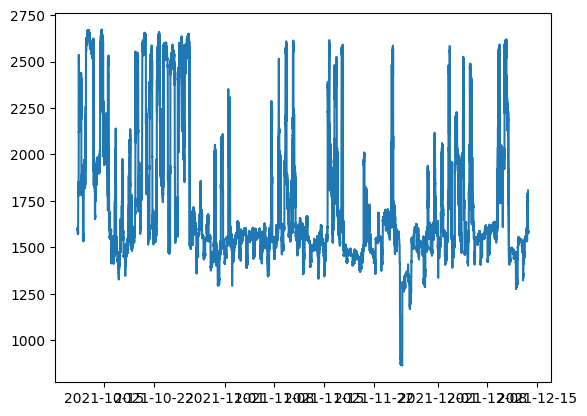

In [423]:
cur_best = pickle.load(open(f'best_model_2023-06-18.pkl', 'rb'))
todays_best = pickle.load(open(f'best_model_{date.today()}.pkl', 'rb'))
print(len(predictions_dates))
test = trainentest.iloc[273988:, :].drop(['demand_kW'], axis=1)


def get_final_predictions(model, data):
    return model.predict(data)
predictions = get_final_predictions(todays_best[0], all_data_predict)
print(len(predictions_dates), len(predictions))
plt.plot(predictions_dates, predictions)
plt.show()


In [427]:
final_pred = pd.DataFrame(predictions_dates, columns = ['datetime_local'])
final_pred['demand_kW'] = predictions
final_pred.to_csv('RF_predictions.csv', index=False)

### 2. Create timeseries dummy for prophet and dummy for timeseries + method for adding lags of a cycle we want to model
##### timeseries_dummy only consists of the range of dates we have for which we have information per minute, because timeseries need to have regular intervals. 


In [14]:
print(test.head(5))
print(train.tail(5))

        Unnamed: 0 datetime_local  demand_kW
273988      273988  10/11/21 6:08        NaN
273989      273989  10/11/21 6:09        NaN
273990      273990  10/11/21 6:10        NaN
273991      273991  10/11/21 6:11        NaN
273992      273992  10/11/21 6:12        NaN
        Unnamed: 0 datetime_local  demand_kW
273983      273983  10/11/21 6:03   2217.847
273984      273984  10/11/21 6:04   2184.012
273985      273985  10/11/21 6:05   2159.482
273986      273986  10/11/21 6:06   2145.155
273987      273987  10/11/21 6:07   2213.599


In [4]:
def addtimecol(df, colname): ####input df and colname 
    df[colname] = pd.to_datetime(df[colname])         
    df['year'] = df[colname].dt.year
    df['month'] = df[colname].dt.month
    df['weekday'] = df[colname].dt.weekday
    df['day'] = df[colname].dt.day
    df['hour'] = df[colname].dt.hour
    df['minute'] = df[colname].dt.minute        
    return df
def weekend(x):
    if x['weekday'] > 4:
        return True
    return False
    

Prepare the pallet movement feature

In [346]:
#dummy_df = base_df.dropna(subset=['demand_kW', 'Temperature', 'Relative Humidity']) 

dummy_df = base_df.copy()
dummy_df = dummy_df.reset_index()
dummy_df = dummy_df.drop(['hour'], axis=1)
dummy_df = dummy_df.drop(['datetime'], axis=1)
dummy_df = dummy_df.drop(['datetime_local'], axis=1)
dummy_df = dummy_df.drop(['datetime_UTC'], axis=1)
dummy_df

dummy_normalized_df = dummy_df.copy()
#Still drop demand_kW NaNs
#dummy_normalized_df = dummy_normalized_df.dropna(subset=['demand_kW'], axis=0)

## Create df to feed to the model

1. create df per minute and ffill in missing values


- Interpolate columns with missing values
- Normalizing columns (Min-max Normalization)
- One-hot encoding categorical columns



2. create time_series dataframe with features that are socalled lags. They contain data about the value of said feature a timespan ago.


### 1. Create new_df  

In [357]:
#print(base_df.index.min())
base_df.set_index(pd.to_datetime(base_df.index))
print(base_df)

                      day  hour  Relative Humidity_interpolated_normalized   
2018-12-31 21:15:00  31.0  21.0                                   0.574302  \
2018-12-31 21:16:00  31.0  21.0                                   0.574302   
2018-12-31 21:17:00  31.0  21.0                                   0.574302   
2018-12-31 21:18:00  31.0  21.0                                   0.574302   
2018-12-31 21:19:00  31.0  21.0                                   0.574302   
...                   ...   ...                                        ...   
2022-01-11 15:51:00   NaN   NaN                                        NaN   
2022-01-11 15:52:00   NaN   NaN                                        NaN   
2022-01-11 15:53:00   NaN   NaN                                        NaN   
2022-01-11 15:54:00   NaN   NaN                                        NaN   
2022-01-11 15:55:00   NaN   NaN                                        NaN   

                     Temperature_interpolated_normalized   
201

In [359]:
new_df = base_df.copy()
new_df = new_df.drop([ 'day','hour','datetime', 'datetime_UTC', 'minute'], axis=1)
print(new_df.columns)

Index(['Relative Humidity_interpolated_normalized',
       'Temperature_interpolated_normalized', 'weight_1h_normalized',
       'weight_5h_normalized', 'weight_10h_normalized',
       'weight_23h_normalized', 'pallet_movement_5min_normalized',
       'doors_open_normalized', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'year_2018',
       'year_2019', 'year_2020', 'year_2021', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'demand_kW', 'year', 'month',
       'weekday', 'datetime_local', 'Relative Humidity', 'Temperature',
       'weight_1h', 'weight_5h', 'weight_10h', 'weight_23h',
       'pallet_movement_5min', 'doors_open'],
      dtype='object')


In [360]:
new_df[10000:10050]

,Relative Humidity_interpolated_normalized,Temperature_interpolated_normalized,weight_1h_normalized,weight_5h_normalized,weight_10h_normalized,weight_23h_normalized,pallet_movement_5min_normalized,doors_open_normalized,weekday_0,weekday_1,...,weekday,datetime_local,Relative Humidity,Temperature,weight_1h,weight_5h,weight_10h,weight_23h,pallet_movement_5min,doors_open
2019-01-07 19:55:00,0.270719,0.573770,0.000000,0.061535,0.174100,0.239030,0.016893,0.333333,True,False,...,0.0,NaT,NaN,NaN,0.0,136306.0,474715.0,853357.0,419.0,6.0
2019-01-07 19:56:00,0.270719,0.573770,0.000000,0.061535,0.174100,0.239030,0.011652,0.388889,True,False,...,0.0,NaT,NaN,NaN,0.0,136306.0,474715.0,853357.0,289.0,7.0
2019-01-07 19:57:00,0.270719,0.573770,0.000000,0.061535,0.174100,0.239030,0.011128,0.388889,True,False,...,0.0,NaT,NaN,NaN,0.0,136306.0,474715.0,853357.0,276.0,7.0
2019-01-07 19:58:00,0.270719,0.573770,0.000000,0.061535,0.174100,0.239030,0.010321,0.388889,True,False,...,0.0,NaT,NaN,NaN,0.0,136306.0,474715.0,853357.0,256.0,7.0
2019-01-07 19:59:00,0.270719,0.573770,0.000000,0.061535,0.174100,0.239030,0.007257,0.444444,True,False,...,0.0,NaT,NaN,NaN,0.0,136306.0,474715.0,853357.0,180.0,8.0
2019-01-07 20:00:00,0.270719,0.573770,0.000000,0.061535,0.174100,0.239030,0.006451,0.444444,True,False,...,0.0,NaT,NaN,NaN,0.0,136306.0,474715.0,853357.0,160.0,8.0
2019-01-07 20:01:00,0.270719,0.573770,0.000000,0.061535,0.174100,0.239030,0.005161,0.444444,True,False,...,0.0,NaT,NaN,NaN,0.0,136306.0,474715.0,853357.0,128.0,8.0
2019-01-07 20:02:00,0.270719,0.573770,0.000000,0.061535,0.174100,0.239030,0.007257,0.444444,True,False,...,0.0,NaT,NaN,NaN,0.0,136306.0,474715.0,853357.0,180.0,8.0
2019-01-07 20:03:00,0.270719,0.573770,0.000000,0.061535,0.174100,0.239030,0.007257,0.444444,True,False,...,0.0,NaT,NaN,NaN,0.0,136306.0,474715.0,853357.0,180.0,8.0
2019-01-07 20:04:00,0.270719,0.573770,0.000000,0.061535,0.165579,0.239030,0.005120,0.444444,True,False,...,0.0,NaT,NaN,NaN,0.0,136306.0,451482.0,853357.0,127.0,8.0


In [361]:
interpolate = ['Temperature', 'Relative Humidity', 'demand_kW']
to_normalize = ['Relative Humidity_interpolated', 'Temperature_interpolated', 'weight_1h',  
                'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min', 'doors_open']
add_one_hot_encoding = ['weekday', 'year', 'month']


for x in interpolate:
    dummy_normalized_df = interpolate_column(dummy_normalized_df, x)
    new_df = interpolate_column(new_df, x)
for x in to_normalize:
    dummy_normalized_df = normalize_column(dummy_normalized_df, x)
    new_df = normalize_column(new_df, x)
for x in add_one_hot_encoding:
    dummy_normalized_df = add_one_hot_encoder(dummy_normalized_df, x)
    new_df = add_one_hot_encoder(new_df, x)

##### New_df contains all datapoints and missing data is filled in, then dropped. 

In [363]:
###This must be zero all across the board

#new_df.resample('1min').last()
for x in new_df.columns:
    print(x, new_df[x].isna().sum())

Relative Humidity_interpolated_normalized 1460693
Temperature_interpolated_normalized 1460693
weight_1h_normalized 339580
weight_5h_normalized 339340
weight_10h_normalized 339040
weight_23h_normalized 338260
pallet_movement_5min_normalized 329877
doors_open_normalized 339040
weekday_0 461310
weekday_1 461310
weekday_2 461310
weekday_3 461310
weekday_4 461310
weekday_5 461310
weekday_6 461310
year_2018 461310
year_2019 461310
year_2020 461310
year_2021 461310
month_1 461310
month_2 461310
month_3 461310
month_4 461310
month_5 461310
month_6 461310
month_7 461310
month_8 461310
month_9 461310
month_10 461310
month_11 461310
month_12 461310
datetime_local 1593761
demand_kW_interpolated 0
weekday_0.0 0
weekday_1.0 0
weekday_2.0 0
weekday_3.0 0
weekday_4.0 0
weekday_5.0 0
weekday_6.0 0
year_2018.0 0
year_2019.0 0
year_2020.0 0
year_2021.0 0
month_1.0 0
month_2.0 0
month_3.0 0
month_4.0 0
month_5.0 0
month_6.0 0
month_7.0 0
month_8.0 0
month_9.0 0
month_10.0 0
month_11.0 0
month_12.0 0


Incoming weight feature preprocessing

In [364]:
###Incoming weight feature preprocessing
#load all data
incoming_weight_1h = load_data('incoming_weight_df_1h.csv')
incoming_weight_5h = load_data('incoming_weight_df_5h.csv')
incoming_weight_10h = load_data('incoming_weight_df_10h.csv')
incoming_weight_23h = load_data('incoming_weight_df.csv')
#rename columns 
incoming_weight_5h = incoming_weight_5h.rename(columns = {'weight_23h' : 'weight_5h'})
incoming_weight_1h = incoming_weight_1h.rename(columns = {'weight_23h' : 'weight_1h'})
incoming_weight_10h = incoming_weight_10h.rename(columns = {'weight_23h' : 'weight_10h'})
#get them to a datetime object
incoming_weight_1h['datetime_local'] = pd.to_datetime(incoming_weight_1h['datetime_local'])
incoming_weight_5h['datetime_local'] = pd.to_datetime(incoming_weight_5h['datetime_local'])
incoming_weight_10h['datetime_local'] = pd.to_datetime(incoming_weight_10h['datetime_local'])
incoming_weight_23h['datetime_local'] = pd.to_datetime(incoming_weight_23h['datetime_local'])
#set index to be datetime
incoming_weight_1h.set_index('datetime_local', inplace=True)
incoming_weight_5h.set_index('datetime_local', inplace=True)
incoming_weight_10h.set_index('datetime_local', inplace=True)
incoming_weight_23h.set_index('datetime_local', inplace=True)
#reshape them to start at 2018-31-12 9:15PM
incoming_weight_1h = incoming_weight_1h[2361:]
incoming_weight_5h = incoming_weight_5h[2330:] 
incoming_weight_10h = incoming_weight_10h[2326:]
incoming_weight_23h = incoming_weight_23h[2323:]
#Drop duplicates
incoming_weight_1h = incoming_weight_1h.loc[~incoming_weight_1h.index.duplicated()]
incoming_weight_5h = incoming_weight_5h.loc[~incoming_weight_5h.index.duplicated()]
incoming_weight_10h = incoming_weight_10h.loc[~incoming_weight_10h.index.duplicated()]
incoming_weight_23h = incoming_weight_23h.loc[~incoming_weight_23h.index.duplicated()]


Do the same for doors

In [365]:
new_df.rename(columns={'demand_kW_interpolated':'demand_kW'}, inplace=True)
new_df = new_df.dropna(subset = ['demand_kW', 'weight_1h_normalized', 'doors_open_normalized', 'pallet_movement_5min_normalized'], axis=0)

In [371]:
### create timeseries_dummy 
starttime = all_data_train['datetime_local'].at[79678]
# print(starttime)
startime = pd.to_datetime(starttime)
onlyminutesstep1 = base_df[:1460735]
onlyminutes = onlyminutesstep1.loc[starttime:]
timeseries_dummy = onlyminutes.copy()
# print(timeseries_dummy.head())

### Create rows for missing minutes
#timeseries_dummy = timeseries_dummy.asfreq(freq = 'T', method = 'pad')

### about 6900 random rows don't have demand, ffill is fill them with the previous amount
timeseries_dummy['demand_kW'] = timeseries_dummy.demand_kW.fillna(method = 'ffill', axis = 0)
prophet_dummy = pd.DataFrame({'ds': timeseries_dummy.index, 'y' : timeseries_dummy['demand_kW']})
prophet_dummy = prophet_dummy.reset_index()
#prophet_dummy.drop(['datetime_local'], axis = 1, inplace = True)

### edit timeseries_dummy just as dummy_dataset
timeseries_dummy.reset_index(inplace = True)
timeseries_dummy.drop(['hour'], axis=1, inplace = True)
timeseries_dummy.drop(['datetime'], axis=1, inplace = True)
timeseries_dummy.drop(['datetime_local'], axis=1, inplace = True)
timeseries_dummy.drop(['datetime_UTC'], axis=1, inplace = True)

### setup a normalized dataframe and normalize it
timeseries_normalized_dummy = timeseries_dummy.copy()
interpolate = ['Temperature', 'Relative Humidity']
to_normalize = ['Relative Humidity_interpolated', 'Temperature_interpolated', 'weight_1h',  
                'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min', 'doors_open']
add_one_hot_encoding = ['weekday', 'year', 'month']


for x in interpolate:
    timeseries_normalized_dummy = interpolate_column(timeseries_normalized_dummy, x)
for x in to_normalize:
    timeseries_normalized_dummy = normalize_column(timeseries_normalized_dummy, x)
for x in add_one_hot_encoding:
    timeseries_normalized_dummy = add_one_hot_encoder(timeseries_normalized_dummy, x)

2019-02-25 05:13:00
                      day hour  Relative Humidity_interpolated_normalized   
2019-02-25 05:13:00  25.0  5.0                                   0.563201  \
2019-02-25 05:14:00  25.0  5.0                                   0.563201   
2019-02-25 05:15:00  25.0  5.0                                   0.563201   
2019-02-25 05:16:00  25.0  5.0                                   0.554254   
2019-02-25 05:17:00  25.0  5.0                                   0.545307   

                     Temperature_interpolated_normalized   
2019-02-25 05:13:00                             0.377049  \
2019-02-25 05:14:00                             0.377049   
2019-02-25 05:15:00                             0.377049   
2019-02-25 05:16:00                             0.380328   
2019-02-25 05:17:00                             0.383607   

                     weight_1h_normalized  weight_5h_normalized   
2019-02-25 05:13:00              0.052279              0.145088  \
2019-02-25 05:14:00   

In [372]:
#These values are added as columns to the timeseries_dummy
#The amount of columns that are added are the amount of lags
#The column used is in the list [col_names]
#The period of which the previous timepoint is taken are the amount of minutes before it, so cycle of a day is 60x24 minutes

def add_lags_of_column(df, col_names, lag = 3, period = 1):
    new_dict={}
    for col_name in col_names:
        new_dict[col_name]=df[col_name]
        # create lagged Series
        for l in range(1,lag+1):
            new_dict['%s_%amin_%d' %(col_name, period,l)]=df[col_name].shift(l*period)
    return pd.DataFrame(new_dict,index=df.index)

In [373]:
add_10_min_cycle = add_lags_of_column(timeseries_dummy, ['pallet_movement_5min', 'doors_open'], 5, 10)
add_1_min_cycle = add_lags_of_column(timeseries_dummy, ['pallet_movement_5min', 'doors_open'], 5, 1)
add_hour_cycle = add_lags_of_column(timeseries_dummy, ['weight_1h', 'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min', 'doors_open'], 5, 60)
add_day_cycle = add_lags_of_column(timeseries_dummy, ['weight_1h', 'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min', 'doors_open'], 5, 1440)
add_week_cycle = add_lags_of_column(timeseries_dummy, ['weight_1h', 'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min', 'doors_open'], 5, 10080)

pd.concat([timeseries_normalized_dummy, add_hour_cycle, add_1_min_cycle, add_10_min_cycle, add_day_cycle, add_week_cycle], axis = 1)


,index,day,Relative Humidity_interpolated_normalized,Temperature_interpolated_normalized,weight_1h_normalized,weight_5h_normalized,weight_10h_normalized,weight_23h_normalized,pallet_movement_5min_normalized,doors_open_normalized,...,pallet_movement_5min_10080min_2,pallet_movement_5min_10080min_3,pallet_movement_5min_10080min_4,pallet_movement_5min_10080min_5,doors_open,doors_open_10080min_1,doors_open_10080min_2,doors_open_10080min_3,doors_open_10080min_4,doors_open_10080min_5
0,2019-02-25 05:13:00,25.0,NaN,NaN,0.180807,0.321903,0.255833,0.36057,0.035318,0.277778,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
1,2019-02-25 05:14:00,25.0,NaN,NaN,0.180807,0.321903,0.255833,0.36057,0.035318,0.277778,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
2,2019-02-25 05:15:00,25.0,NaN,NaN,0.180807,0.321903,0.255833,0.36057,0.033302,0.277778,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
3,2019-02-25 05:16:00,25.0,NaN,NaN,0.180807,0.321903,0.255833,0.36057,0.029271,0.277778,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
4,2019-02-25 05:17:00,25.0,NaN,NaN,0.180807,0.321903,0.255833,0.36057,0.027658,0.277778,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381052,37,NaN,0.736372,0.075,NaN,NaN,NaN,NaN,NaN,NaN,...,926.0,620.0,635.0,0.0,NaN,3.0,4.0,4.0,6.0,0.0
1381053,38,NaN,1.000000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,...,902.0,1020.0,781.0,0.0,NaN,3.0,4.0,4.0,6.0,0.0
1381054,39,NaN,1.000000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,...,1054.0,706.0,697.0,0.0,NaN,3.0,4.0,4.0,6.0,0.0
1381055,40,NaN,1.000000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,...,1032.0,553.0,577.0,0.0,NaN,2.0,4.0,4.0,6.0,0.0


# Model Building
- 1 divide into train/test 
- 2 set target column
- 3 get accuracy

https://stats.stackexchange.com/questions/139042/ensemble-of-different-kinds-of-regressors-using-scikit-learn-or-any-other-pytho
Id like to try this, an ensemble of multiple models



In [374]:
#load data
pallet_move_5min = load_data('pallet_movement_5min_ft.csv')
#rename column
pallet_move_5min.rename(columns = {'quantity' : 'pallet_movement_5min'}, inplace = True)
#make index a datetime object and set as index
pallet_move_5min['datetime_local'] = pd.to_datetime(pallet_move_5min['datetime_local'])
pallet_move_5min.set_index('datetime_local', inplace = True)
#delete duplicates
pallet_move_5min = pallet_move_5min.loc[~pallet_move_5min.index.duplicated()]

Dummy drops things that are NA, maybe sth to look at

# 1. Train and Testset
Things to look at:
1. how to divide test/train/holdout set

In [342]:
base_door = load_data("feature_inbound_outbound_door_open.csv")
base_door = base_door.rename(columns = {'total' : 'doors_open'})
base_door['datetime_local'] = pd.to_datetime(base_door['datetime_local'])
base_door.set_index('datetime_local', inplace=True)

In [356]:
#Create new dummy dfs
base_df = all_data_train.copy()
base_weather = weather.copy()

#Remove unnecessary columns
#base_df = base_df.drop('Unnamed: 0', axis=1)
base_weather = base_weather.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
base_weather["localstrptime"]= pd.to_datetime(base_weather["localstrptime"])
base_df['datetime_local'] = pd.to_datetime(base_df['datetime_local'])
base_weather = base_weather.rename(columns={'localstrptime':'datetime_local'})
#base_weather['datetime_local'] = [datetime.datetime.strptime(x, 'yyyy/MM/dd HH:mm:SS') for x in base_weather['localstrptime']]

#Add pallet movements feature
##

#Add time columns.
addtimecol(base_df, 'datetime_local')

#Set index to datetime
base_df.set_index('datetime_local', inplace=True)
#base_weather.set_index('datetime_local', inplace=True)
#Concatenate the weather DataFrame to the base DataFrame 
base_df = pd.concat([base_df, base_weather], axis=1)


#Concatenate the incoming weight dataframe with the base dataframe
base_df = pd.concat([base_df, incoming_weight_1h], axis=1)
base_df = pd.concat([base_df, incoming_weight_5h], axis=1)
base_df = pd.concat([base_df, incoming_weight_10h], axis=1)
base_df = pd.concat([base_df, incoming_weight_23h], axis=1)

#Concatenate the pallet movement feature
base_df = pd.concat([base_df, pallet_move_5min], axis = 1)

#Concatenate the door feature
base_df = pd.concat([base_df, base_door], axis=1)



In [381]:
#Define train, test sets\n",

allyears_df = new_df.copy()

train, test = train_test_split(allyears_df, shuffle=True)
X_train = train.copy().drop(['demand_kW'], axis=1)
Y_train = train['demand_kW']
X_test = test.copy().drop(['demand_kW'], axis=1)
Y_test = test['demand_kW']

#lastmonth_df = allyears_df[].copy()


In [382]:
allyears_df

,index,datetime_local,day,hour,Relative Humidity_interpolated_normalized,Temperature_interpolated_normalized,weight_1h_normalized,weight_5h_normalized,weight_10h_normalized,weight_23h_normalized,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,demand_kW
0,1052805,2021-01-01 00:00:00,1,0,1.000000,0.327869,0.000000,0.000000,0.040435,0.159323,...,False,False,False,False,False,False,False,False,False,1079.447687
1,1052806,2021-01-01 00:01:00,1,0,1.000000,0.327869,0.000000,0.000000,0.040435,0.159323,...,False,False,False,False,False,False,False,False,False,1077.942488
2,1052807,2021-01-01 00:02:00,1,0,1.000000,0.327869,0.000000,0.000000,0.040435,0.159323,...,False,False,False,False,False,False,False,False,False,1076.437288
3,1052808,2021-01-01 00:03:00,1,0,1.000000,0.327869,0.000000,0.000000,0.040435,0.159323,...,False,False,False,False,False,False,False,False,False,1074.932089
4,1052809,2021-01-01 00:04:00,1,0,1.000000,0.327869,0.000000,0.000000,0.040435,0.159323,...,False,False,False,False,False,False,False,False,False,1073.426890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320043,1372848,2021-08-11 06:03:00,11,6,0.817213,0.704918,0.017878,0.074735,0.178824,0.344463,...,False,False,False,False,True,False,False,False,False,2891.324000
320044,1372849,2021-08-11 06:04:00,11,6,0.817213,0.704918,0.017878,0.074735,0.178824,0.344463,...,False,False,False,False,True,False,False,False,False,2878.348000
320045,1372850,2021-08-11 06:05:00,11,6,0.817213,0.704918,0.017878,0.074735,0.178824,0.344463,...,False,False,False,False,True,False,False,False,False,2970.997000
320046,1372851,2021-08-11 06:06:00,11,6,0.817213,0.704918,0.017878,0.074735,0.178824,0.344463,...,False,False,False,False,True,False,False,False,False,2977.854000


# Test set creation

Creating the test set with the desired features.

In [383]:
pred_df = test.copy().drop(['Unnamed: 0', 'demand_kW'],  axis=1)
pred_df['datetime_local'] = pd.to_datetime(pred_df['datetime_local'])
addtimecol(pred_df, 'datetime_local')
pred_dates = pred_df.index
pred_weather = base_weather[base_weather.index.isin(pred_dates)]
print(pred_df.shape)
#Adding weather
pred_df = pd.concat([pred_df, pred_weather], axis=1)
#pred_df = pred_df.drop(['datetime', 'datetime_UTC'])
print(pred_df.shape)
pred_df = pd.concat([pred_df, incoming_weight_1h[incoming_weight_1h.index.isin(pred_dates)]], axis=1)
pred_df = pd.concat([pred_df, incoming_weight_5h[incoming_weight_5h.index.isin(pred_dates)]], axis=1)
pred_df = pd.concat([pred_df, incoming_weight_10h[incoming_weight_10h.index.isin(pred_dates)]], axis=1)
pred_df = pd.concat([pred_df, incoming_weight_23h[incoming_weight_23h.index.isin(pred_dates)]], axis=1)
pred_df = pd.concat([pred_df, pallet_move_5min[pallet_move_5min.index.isin(pred_dates)]], axis = 1)
pred_df = pd.concat([pred_df, base_door[base_door.index.isin(pred_dates)]], axis=1)
print(pred_df.shape)
pred_df = pred_df.drop([ 'day','hour','datetime', 'datetime_UTC', 'minute', 'datetime_local'], axis=1)
print(pred_df.shape)
interpolate = ['Temperature', 'Relative Humidity']
to_normalize = ['Relative Humidity_interpolated', 'Temperature_interpolated', 'weight_1h',  
                'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min', 'doors_open']
add_one_hot_encoding = ['weekday', 'year', 'month']

for x in interpolate:
    pred_df = interpolate_column(pred_df, x)
for x in to_normalize:
    pred_df = normalize_column(pred_df, x)
for x in add_one_hot_encoding:
    pred_df = add_one_hot_encoder(pred_df, x)

KeyError: "['Unnamed: 0'] not found in axis"

In [208]:
pred_df.dtypes

Relative Humidity_interpolated_normalized    float64
Temperature_interpolated_normalized          float64
weight_1h_normalized                         float64
weight_5h_normalized                         float64
weight_10h_normalized                        float64
weight_23h_normalized                        float64
pallet_movement_5min_normalized              float64
doors_open_normalized                        float64
weekday_0                                       bool
weekday_1                                       bool
weekday_2                                       bool
weekday_3                                       bool
weekday_4                                       bool
weekday_5                                       bool
weekday_6                                       bool
year_2021                                       bool
month_10                                        bool
month_11                                        bool
month_12                                      

In [384]:
#Creating the DF for the test set.
predicting_df = test.copy().drop(['Unnamed: 0', 'demand_kW'], axis=1)
predicting_df['datetime_local'] = pd.to_datetime(predicting_df['datetime_local'])
addtimecol(predicting_df, 'datetime_local')
#predicting_df.set_index('datetime_local', inplace=True)
predicting_df = pd.concat([predicting_df, base_weather], axis=1)
predicting_df = pd.concat([predicting_df, incoming_weight_1h], axis=1)
predicting_df = pd.concat([predicting_df, incoming_weight_5h], axis=1)
predicting_df = pd.concat([predicting_df, incoming_weight_10h], axis=1)
predicting_df = pd.concat([predicting_df, incoming_weight_23h], axis=1)
predicting_df = pd.concat([predicting_df, pallet_move_5min], axis = 1)
predicting_df = pd.concat([predicting_df, base_door], axis=1)
predicting_df = predicting_df.reset_index()
predicting_df = predicting_df.drop([ 'day','hour','datetime', 'datetime_UTC', 'minute', 'datetime_local'], axis=1)
print(predicting_df)

interpolate = ['Temperature', 'Relative Humidity']
to_normalize = ['Relative Humidity_interpolated', 'Temperature_interpolated', 'weight_1h',  
                'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min', 'doors_open']
add_one_hot_encoding = ['weekday', 'year', 'month']


for x in interpolate:
    dummy_normalized_df = interpolate_column(dummy_normalized_df, x)
    new_df = interpolate_column(new_df, x)
for x in to_normalize:
    dummy_normalized_df = normalize_column(dummy_normalized_df, x)
    new_df = normalize_column(new_df, x)
for x in add_one_hot_encoding:
    dummy_normalized_df = add_one_hot_encoder(dummy_normalized_df, x)
    new_df = add_one_hot_encoder(new_df, x)

KeyError: "['Unnamed: 0'] not found in axis"

# 3. Model Selection
1. Import methods/models

2. standard formulas 

C:\Users\Rob Pennekamp\AppData\Local\Temp\ipykernel_22696\898817105.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{colname}_interpolated'] = df[colname].interpolate(method='linear')


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

## Standard formulas


In [209]:
""" create test and trainsets for GB, y2021 and last months seperate """
RF_df = allyears_df.copy()
print(RF_df.dtypes)
RF_lastmonths = RF_df.loc['2021-11-03 18:57:00':]
RF_train, RF_test = train_test_split(RF_df.loc[:'2021-11-03 18:57:00'], shuffle=False)
X_RF_train = RF_train.copy().drop(['demand_kW'], axis=1)
Y_RF_train = RF_train['demand_kW']
X_RF_test = RF_test.copy().drop(['demand_kW'], axis=1)
Y_RF_test = RF_test['demand_kW']
X_RF_lastmonths = RF_lastmonths.copy().drop(['demand_kW'], axis=1)
Y_RF_lastmonths = RF_lastmonths['demand_kW']
RF_data = X_RF_train, Y_RF_train, X_RF_test, Y_RF_test, X_RF_lastmonths, Y_RF_lastmonths

GB_df = allyears_df.copy()
add_10_min_cycle = add_lags_of_column(GB_df, ['pallet_movement_5min_normalized', 'doors_open_normalized'], 2, 10) 
add_hour_cycle = add_lags_of_column(GB_df, ['weight_23h_normalized', 'doors_open_normalized'], 2, 60) 
add_day_cycle = add_lags_of_column(GB_df, ['weight_23h_normalized',], 6, 1440)
GB_df = pd.concat([GB_df, add_hour_cycle, add_10_min_cycle, add_day_cycle], axis = 1)

GB_df = GB_df.dropna()
GB_df['hour'] = pd.to_datetime(GB_df.index).hour
y2021_df = GB_df[GB_df.index.year == 2021]
y2021_df = y2021_df.drop(columns = ['year_2021.0', 'year_2020.0', 'year_2019.0', 'year_2018.0'], axis = 1)

train, test = train_test_split(allyears_df.loc[:'2021-11-03 18:57:00'], shuffle=True)
y2021_train, y2021_test = train_test_split(y2021_df.loc[:'2021-11-03 18:57:00'], shuffle=True)
lags_train, lags_test = train_test_split(GB_df[:'2021-11-03 18:57:00'], shuffle=True)

lastmonths = allyears_df.loc['2021-11-03 18:57:00':]
#lastmonths = lastmonths.drop(columns = ['year_2021.0', 'year_2020.0', 'year_2019.0', 'year_2018.0'], axis = 1)
lastmonths_Y_test = lastmonths['demand_kW']
lastmonths_X_test = lastmonths.copy().drop(['demand_kW'], axis=1)

GB_df = GB_df.reset_index().drop('index', axis = 1)

X_train = train.copy().drop(['demand_kW'], axis=1)
Y_train = train['demand_kW']
X_test = test.copy().drop(['demand_kW'], axis=1)
Y_test = test['demand_kW']

y2021_X_train = y2021_train.copy().drop(['demand_kW'], axis=1)
y2021_Y_train = y2021_train['demand_kW']
y2021_X_test = y2021_test.copy().drop(['demand_kW'], axis=1)
y2021_Y_test = y2021_test['demand_kW']

lags_X_train = lags_train.copy().drop(['demand_kW'], axis=1)
lags_Y_train = lags_train['demand_kW']
lags_X_test = lags_test.copy().drop(['demand_kW'], axis=1)
lags_Y_test = lags_test['demand_kW']

data = X_train, Y_train, X_test, Y_test
y2021_data =y2021_X_train, y2021_Y_train, y2021_X_test, y2021_Y_test
lags_data =  lags_X_train, lags_Y_train, lags_X_test, lags_Y_test

demand_kW                                    float64
Relative Humidity_interpolated_normalized    float64
Temperature_interpolated_normalized          float64
weight_1h_normalized                         float64
weight_5h_normalized                         float64
weight_10h_normalized                        float64
weight_23h_normalized                        float64
pallet_movement_5min_normalized              float64
doors_open_normalized                        float64
weekday_0.0                                     bool
weekday_1.0                                     bool
weekday_2.0                                     bool
weekday_3.0                                     bool
weekday_4.0                                     bool
weekday_5.0                                     bool
weekday_6.0                                     bool
year_2018.0                                     bool
year_2019.0                                     bool
year_2020.0                                   

In [70]:
def test_model(model, data, debug=False, freq = 'min', get_model = False):            
   
    xtrain, ytrain, xtest, ytest, xlastmonths, ylastmonths = data
    if freq != 'min':
        xtrain_resampled = xtrain.copy().resample(freq).last()
        ytrain_resampled = ytrain.copy().resample(freq).last()
    else:
        xtrain_resampled = xtrain.copy()
        ytrain_resampled = ytrain.copy()
    
    if debug:
        print("Fitting model...")
    model.fit(xtrain_resampled, ytrain_resampled)
    if debug:
        print('Predicting...')
    
    acc_train = model.predict(xtrain)
    acc_test = model.predict(xtest)
    acc_lastmonths = model.predict(xlastmonths)
    if debug:
        print('Calculating rmse...')     
    if get_model:
        print('test:  ', mean_squared_error(list(ytest), acc_test, squared = False), "train:    ", mean_squared_error(list(ytrain), acc_train, squared = False), "month:    ", mean_squared_error(list(lastmonths_Y_test), acc_lastmonths, squared = False))
        return model
    return mean_squared_error(list(ytrain), acc_train, squared = False), mean_squared_error(list(ytest), acc_test, squared = False), mean_squared_error(list(ylastmonths), acc_lastmonths, squared = False),

In [56]:
def do_cross_val(model, df, freq = "Min", folds = 5):   
    
    train, test = train_test_split(df, shuffle = True)
    
    Y_train = train['demand_kW']
    X_train = train.copy().drop(["demand_kW"], axis = 1)
    
    X_train = X_data.resample(freq).last()
    Y_train = Y_data.resample(freq).last()
    
    Y_test = test['demand_kW']
    X_train =  test.copy().drop(["demand_kW"], axis = 1)    
    
    cross_val_score(GB_model, X_data, Y_data, cv = folds, scoring = 'metric.mean_squared_error')


In [281]:
def model_optimizer(data, model, params, freq = 'min'):
    parameter_combinations = itertools.product(*params.values())
    results = {}
    for parameters in parameter_combinations:
        start = time.time()
        params_dict = dict(zip(params.keys(), parameters))
        print('Testing model with parameters: ' + str(params_dict))
        current_model = model(**params_dict)
        rmse_train, rmse_test = test_model(current_model, data, debug = False, freq = freq)
        print(f'Root Mean Squared Error Train = {rmse_train}')
        print(f'Root Mean Squared Error Test = {rmse_test}')
        modelname = str(params_dict)
        end = time.time()
        print(f'Time spent: {end-start} seconds. \n')
        results[modelname] = [rmse_train, rmse_test, (end-start), model]
    return results

In [58]:
def run_timeseries_model(data, model, n_splits = 5, verbose=False, freq = 'Min'):
    """
    Function which receives a data and a model as input.
    Can also receive the amount of splits you want as input.
    For debugging purposes, set verbose to True.
    
    Outputs a list of:
        - The resulting model
        - The final RMSE
        - A list of the resulting Train RMSEs (per fold)
        - A list of the resulting Test RMSEs (per fold)
    """          

    ts = TimeSeriesSplit(n_splits=n_splits)

    count = 1
    train_rmses = []
    test_rmses = []
    for train, test in ts.split(data):
        if verbose:            
            print(f'Starting fold {count}')
        cv_train, cv_test = data.iloc[train], data.iloc[test]
        
        cv_train = cv_train.copy().resample(freq).last()
        y_train = cv_train['demand_kW']        
        print('y_train:', y_train)
        x_train = cv_train.drop(['demand_kW'], axis=1)
        
        y_test = cv_test['demand_kW']
        print('y_test:', y_test)
        x_test = cv_test.drop(['demand_kW'], axis=1)
        if verbose:
            print("Training model...")
        model.fit(x_train, y_train)
        if verbose:
            print("Predicting...")
        y_pred_test = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        if verbose:
            print("Calculating rmse's...")
        
        train_rmse = mean_squared_error(y_train, y_pred_train) #, squard = false)
        test_rmse = mean_squared_error(y_test, y_pred_test) #, squard = false)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        if verbose:
            print(f'Fold {count} train error: {train_rmse}. Test error: {test_rmse}.')
        count += 1
    return [model, test_rmse, train_rmses, test_rmses]

    
    

In [83]:
import itertools
import pickle
from datetime import date

def find_optimal_parameters(data, model, params, n_splits=2, verbose=False, freq = 'min'):
    """
    Function which will find the optimal parameters within set boudaries.
    Receives as input:
    - The data
    - A model
    - The dictionary of parameters to optimize:
        - Key: parameter name
        - Value: List of testing parameter values.
    - The amount of Timeseries splits for crossvalidation (Standard: 5)
    - Whether information should be printed or not (Standard: False)
    """
    
    parameter_combinations = itertools.product(*params.values())
    results = {}
    count = 1
    for x in parameter_combinations:
        model_name = f'Model {count}'
        results[model_name] = [dict(zip(params.keys(), x))]
        count +=1
    lowest = 1000000000
    best_model = ""
    print(results['Model 1'])
    for model_name in results.keys():
        params_dict = results[model_name][0]
        #print(f'Testing model {model_name} with parameters: {params_dict}')
        current_model = model(**params_dict)
        results[model_name].append(test_model(current_model,data, freq = freq))
        #results[model_name].append(run_timeseries_model(data, current_model, n_splits=n_splits, verbose=verbose, freq = freq))
        #print(results[model_name])
        print(f'Finished testing model.{params_dict} Train RMSE: {results[model_name][1][0]}, Test RMSE: {results[model_name][1][1]}, LastMonths RMSE: {results[model_name][1][2]}')
        if results[model_name][1][2] < lowest:
            lowest = results[model_name][1][2]
            best_model = current_model
            best_model_name = model_name
    try: 
        cur_best = pickle.load(open(f'best_model_{date.today()}.pkl', 'rb'))[1]
        if cur_best > lowest:
            print("New best rmse reached! Pickling model.")
            pickle.dump([best_model, lowest, best_model_name], open(f"Best_model_{date.today()}.pkl", 'wb'))
        else:
            print("RMSE of best model does not improve on the best model of today. Not saving model.")
    except FileNotFoundError:
        print("New best rmse reached! Pickling model.")
        pickle.dump([best_model, lowest, best_model_name], open(f"Best_model_{date.today()}.pkl", 'wb'))
    return results

# Model Testing 

model decision
N is big, we have many datapoints

Overfitting/underfitting, you want training set to be too small to overfit

#### Gradient boosting
1. test resample data so that it is per hour/minute/15minutes/day
2. parameter settings
3. feature importance + lags
3. regular cross validation, predicting next 2 months 


results
1. big difference when overfitting happens between h/d/15min 
2. do we want timeseries cross validation for this as well? No, because that is not how GB works, yes because it is the task at hand. 

2. n_estimators more than 800 doesn't make test/train more accurate, no overfitting even when higher
max depth more than 12 doesn't make test/train more accurate, no overfitting even when higher
best so far is n_estimators = 800, max depth = 11, no overfitting here but can't get accuracy higher, also last months accuracy is 400, very bad

Model n_estimators 700, depth 12, 15min, data from all years
Train RMSE: 75.79718787967745, Test RMSE: 76.07328450184008, LastMonths RMSE: 379.3295109528706

3
'Relative Humidity_interpolated_normalized': 0.027063782647336842,
 'Temperature_interpolated_normalized': 0.7473017287659173,
 'weight_1h_normalized': 0.0,
 'weight_5h_normalized': 0.00044825629713856935,
 'weight_10h_normalized': 0.00014497021584651695,
 'weight_23h_normalized': 0.01564081058423913,
 'pallet_movement_5min_normalized': 0.0,
 'doors_open_normalized': 0.00010266489111533081,
 'weekday_0.0': 0.0,
 'weekday_1.0': 0.0,
 'weekday_2.0': 0.0,
 'weekday_3.0': 0.0,
 'weekday_4.0': 0.0,
 'weekday_5.0': 0.0,
 'weekday_6.0': 0.0,
 'year_2018.0': 0.0,
 'year_2019.0': 0.0,
 'year_2020.0': 0.0,
 'year_2021.0': 0.08078559508441438,
 'month_1.0': 0.0,
 'month_2.0': 0.0,
 'month_3.0': 0.0,
 'month_4.0': 0.0,
 'month_5.0': 0.0,
 'month_6.0': 0.0024826248476889816,
 'month_7.0': 0.0003337986485462298,
 'month_8.0': 0.0006518835972989488,
 'month_9.0': 0.0007318382873058085,
 'month_10.0': 0.0,
 'month_11.0': 0.0,
 'month_12.0': 0.0,
 'hour': 0.007396925774009665,
 
 
 
 
 Steps
 1: create all features df and all possible lags, test feature relevance
 2: Select only relevant/most relevant features += 51, improved accuracy for both test and train by RMSE being 75 instead of 125, so 50 more accurate, but last month still an RMSE of 370
 3: 

In [76]:
##CV
#GB_model = GradientBoostingRegressor(**test_parameters)

#Y_data = allyears_df['demand_kW']
#X_data = allyears_df.copy().drop(["demand_kW"], axis = 1)
model_GB = GradientBoostingRegressor
model_RF = RandomForestRegressor
#do_cross_val(GB_model, allyears_df, freq = 'h', folds=5)

## RUN THIS

# Random Forest

### Parameter settings:

Testing parameters to find the best setting. For a while, the standard settings were best. However, with the inclusion of the frequency of data being another factor, messing around with the model parameters was beneficial.

#### Sampling frequency
Having tested every minute, every 15 minutes, one hour, one day and each week, we've found that every hour is the optimal sampling rate for Random Forest.

#### n_estimators
We've found that, in general, more estimators is better but that it flattens out at ~300 estimators.

#### bootstrap
True is significantly better in combination with all other parameters.

#### loss function
squared error had best performance

#### max_depth
An unlimited amount of depth is better in general, but performance flattens out at a depth of 12 with the amount of features in the final dataframe. For speed, this is set as the limit.

In [77]:
print(data[0].columns, data[2].columns)

Index(['Relative Humidity_interpolated_normalized',
       'Temperature_interpolated_normalized', 'weight_1h_normalized',
       'weight_5h_normalized', 'weight_10h_normalized',
       'weight_23h_normalized', 'pallet_movement_5min_normalized',
       'doors_open_normalized', 'weekday_0.0', 'weekday_1.0', 'weekday_2.0',
       'weekday_3.0', 'weekday_4.0', 'weekday_5.0', 'weekday_6.0',
       'year_2018.0', 'year_2019.0', 'year_2020.0', 'year_2021.0', 'month_1.0',
       'month_2.0', 'month_3.0', 'month_4.0', 'month_5.0', 'month_6.0',
       'month_7.0', 'month_8.0', 'month_9.0', 'month_10.0', 'month_11.0',
       'month_12.0'],
      dtype='object') Index(['Relative Humidity_interpolated_normalized',
       'Temperature_interpolated_normalized', 'weight_1h_normalized',
       'weight_5h_normalized', 'weight_10h_normalized',
       'weight_23h_normalized', 'pallet_movement_5min_normalized',
       'doors_open_normalized', 'weekday_0.0', 'weekday_1.0', 'weekday_2.0',
       'weekday_3.0

In [297]:
RF_parameters = {
    'n_estimators': [300],
    'criterion': ['squared_error'],    
    'max_depth': [12],
    'bootstrap': [True],
    'max_features': [None]
    }

#test_model(model_GB(), data, freq = 'h') 
freqs = ['min', '15min', '1h', '1d']
for freq in freqs:
    find_optimal_parameters(training_data, model_RF, RF_parameters, freq = freq)

[{'n_estimators': 300, 'criterion': 'squared_error', 'max_depth': 12, 'bootstrap': True, 'max_features': None}]
137286
137286
Finished testing model.{'n_estimators': 300, 'criterion': 'squared_error', 'max_depth': 12, 'bootstrap': True, 'max_features': None} Train RMSE: 132.62253137497538, Test RMSE: 817.2967337545555, LastMonths RMSE: 829.6874347046056
RMSE of best model does not improve on the best model of today. Not saving model.
[{'n_estimators': 300, 'criterion': 'squared_error', 'max_depth': 12, 'bootstrap': True, 'max_features': None}]
137286
137286
Finished testing model.{'n_estimators': 300, 'criterion': 'squared_error', 'max_depth': 12, 'bootstrap': True, 'max_features': None} Train RMSE: 128.44922609788694, Test RMSE: 829.6251730315493, LastMonths RMSE: 838.486617267986
RMSE of best model does not improve on the best model of today. Not saving model.
[{'n_estimators': 300, 'criterion': 'squared_error', 'max_depth': 12, 'bootstrap': True, 'max_features': None}]
137286
137286

# Test Function

In [299]:
cur_best = pickle.load(open(f'best_model_2023-06-18.pkl', 'rb'))
print(cur_best)
print(training_data[0].dtypes)
test = trainentest.iloc[273988:, :].drop(['demand_kW'], axis=1)
print(pred_df)
def get_final_predictions(model, data):
    return model.predict(data)

get_final_predictions(cur_best[0], pred_df)





[RandomForestRegressor(max_depth=12, max_features=None, n_estimators=300), 549.6102378666478, 'Model 1']
day                                            int64
hour                                           int64
Relative Humidity_interpolated_normalized    float64
Temperature_interpolated_normalized          float64
weight_1h_normalized                         float64
weight_5h_normalized                         float64
weight_10h_normalized                        float64
weight_23h_normalized                        float64
pallet_movement_5min_normalized              float64
doors_open_normalized                        float64
weekday_0                                       bool
weekday_1                                       bool
weekday_2                                       bool
weekday_3                                       bool
weekday_4                                       bool
weekday_5                                       bool
weekday_6                                      

NameError: name 'pred_df' is not defined

In [142]:
GB_parameters = {
    'n_estimators': [300,500, 700, 900],
    'loss': ['squared_error'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [8, 12]    
    }

#test_model(model_GB(), data, freq = 'h') 
freqs = ['15min', '1h', '1d']
for freq in freqs:
    find_optimal_parameters(training_data, model_RF, RF_parameters, freq = freq)

[{'n_estimators': 300, 'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 8}]


KeyboardInterrupt: 

In [94]:
GB_parameters = {
    'n_estimators': [100,300,500, 700],
    'loss': ['squared_error'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [5, 8, 12]
    }

#test_model(model_GB(), data, freq = 'h') 
find_optimal_parameters(lags_data, model_GB, GB_parameters, freq = '15min')

#Optimization completed. Best model is Model 12 with parameters [{'n_estimators': 700, 'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 12}, (75, 75, 380.3625887176132)]. 


[{'n_estimators': 100, 'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 5}]
Finished testing model.{'n_estimators': 100, 'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 5} Train RMSE: 225.98060812260812, Test RMSE: 225.02673049647376, LastMonths RMSE: 367.3228713755333
Finished testing model.{'n_estimators': 100, 'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 8} Train RMSE: 163.28363544681918, Test RMSE: 162.61555778291086, LastMonths RMSE: 368.75201029063595
Finished testing model.{'n_estimators': 100, 'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 12} Train RMSE: 90.61043420045058, Test RMSE: 90.42903480582972, LastMonths RMSE: 378.8226602198736
Finished testing model.{'n_estimators': 300, 'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 5} Train RMSE: 197.55007854091332, Test RMSE: 196.9716410147955, LastM

{'Model 1': [{'n_estimators': 100,
   'loss': 'squared_error',
   'learning_rate': 0.1,
   'max_leaf_nodes': None,
   'max_depth': 5},
  (225.98060812260812, 225.02673049647376, 367.3228713755333)],
 'Model 2': [{'n_estimators': 100,
   'loss': 'squared_error',
   'learning_rate': 0.1,
   'max_leaf_nodes': None,
   'max_depth': 8},
  (163.28363544681918, 162.61555778291086, 368.75201029063595)],
 'Model 3': [{'n_estimators': 100,
   'loss': 'squared_error',
   'learning_rate': 0.1,
   'max_leaf_nodes': None,
   'max_depth': 12},
  (90.61043420045058, 90.42903480582972, 378.8226602198736)],
 'Model 4': [{'n_estimators': 300,
   'loss': 'squared_error',
   'learning_rate': 0.1,
   'max_leaf_nodes': None,
   'max_depth': 5},
  (197.55007854091332, 196.9716410147955, 365.53654912040287)],
 'Model 5': [{'n_estimators': 300,
   'loss': 'squared_error',
   'learning_rate': 0.1,
   'max_leaf_nodes': None,
   'max_depth': 8},
  (123.33603747751364, 123.28007033187585, 365.92759991192116)],
 'Mo

In [138]:
model = test_model(model_GB(), y2021_data, GB_parameters, freq = 'h', get_model = True)

Fitting model...
Predicting...
Calculating rmse...
test:   253.77281573339963 train:     253.54159239385544 month:     384.40614357068625


#### Test for feature importance
Findings, skip features as mentioned with a score below 0.001

In [140]:
model.feature_importances_
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(y2021_train.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 
feats

{'demand_kW': 0.020482922514613283,
 'Relative Humidity_interpolated_normalized': 0.718171340490816,
 'Temperature_interpolated_normalized': 0.00038337726093910616,
 'weight_1h_normalized': 0.0015480915268605202,
 'weight_5h_normalized': 0.00037545983249796545,
 'weight_10h_normalized': 0.01659833144202636,
 'weight_23h_normalized': 0.00814276308676642,
 'pallet_movement_5min_normalized': 0.00044494229701486993,
 'doors_open_normalized': 0.0006571015641084766,
 'weekday_0.0': 0.002631633085561411,
 'weekday_1.0': 0.003775908006201023,
 'weekday_2.0': 0.004581127410363124,
 'weekday_3.0': 0.0029043180320885197,
 'weekday_4.0': 0.004579440153149607,
 'weekday_5.0': 0.003197966083960725,
 'weekday_6.0': 0.0,
 'month_1.0': 0.0,
 'month_2.0': 0.0,
 'month_3.0': 0.0,
 'month_4.0': 0.007741016737074412,
 'month_5.0': 0.007711021485799343,
 'month_6.0': 0.010195992857805028,
 'month_7.0': 0.010308872030482816,
 'month_8.0': 0.016573601200501904,
 'month_9.0': 0.008231817508606267,
 'month_10.0

#### Test for all year data vs only year 2021
findings: year 2021 only makes score lower

In [122]:
GB_parameters = {
    'n_estimators': [700],
    'loss': ['squared_error'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [12]
    }

#test_model(model_GB(), data, freq = 'h') 
find_optimal_parameters(y2021_data, model_GB, GB_parameters, freq = '15min')

#Findings best model that didn't overfit = Optimization completed. Best model is Model 12 with parameters [{'n_estimators': 800, 'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 11}, (197.66402033628637, 198.71073705157008)]. 
 #RMSE is 198.71073705157008.

[{'n_estimators': 700, 'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 12}]
Finished testing model.{'n_estimators': 700, 'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 12} Train RMSE: 147.02200993291225, Test RMSE: 146.08719350539027, LastMonths RMSE: 129.89725438907774
Optimization completed. Best model is Model 1 with parameters [{'n_estimators': 700, 'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 12}, (147.02200993291225, 146.08719350539027, 129.89725438907774)]. 
 RMSE is 146.08719350539027.


{'Model 1': [{'n_estimators': 700,
   'loss': 'squared_error',
   'learning_rate': 0.1,
   'max_leaf_nodes': None,
   'max_depth': 12},
  (147.02200993291225, 146.08719350539027, 129.89725438907774)]}

#### Test for different frequency datapoints
findings: minute data takes too long
          hour and 15 minutes has little difference
          day is much worse

In [161]:
find_optimal_parameters(data, model_GB, GB_parameters, freq = '15min')

# best model that didn't overfit = [{'n_estimators': 800, 'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 11}, (128.16285716744068, 131.32000153089484)]. 
# RMSE is 131.32000153089484.

[{'n_estimators': 800, 'loss': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 11}]


KeyboardInterrupt: 

In [123]:
#find_optimal_parameters(y2021_data, model_GB, GB_parameters, freq = 'min') #Dit duurt veel te lang

(1460693, 25)
(91432, 24)
datetime_local                               datetime64[ns]
Relative Humidity                                   float64
Temperature                                         float64
weight_1h                                           float64
weight_5h                                           float64
weight_10h                                          float64
weight_23h                                          float64
pallet_movement_5min                                float64
doors_open                                          float64
year                                                  int64
month                                                 int64
weekday                                               int64
day                                                   int64
hour                                                  int64
Temperature_interpolated                            float64
Relative Humidity_interpolated                      float64
Relative Humid

In [156]:
"""results:
n_estimators = 400; depth of 11 causes overfitting, best testscore of 150 is at lr = 0.1 and max depth 11. 
n_estimators = 600; depth of 11 causes overfitting, best testscore of 130 at lr=0.1 and max depth 11 but max depth 9 is without much overfitting 150
"""


GB_parameters = {
    'n_estimators': [100],
    'criterion': ['squared_error'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [4]
    }

model_GB = GradientBoostingRegressor()

test_GB = model_optimizer(data, model_GB, GB_parameters, freq = '15Min')

Testing model with parameters: {'n_estimators': 100, 'criterion': 'squared_error', 'learning_rate': 0.1, 'max_leaf_nodes': None, 'max_depth': 4}


C:\Users\sonja\Anaconda3\lib\site-packages\sklearn\base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- doors_open_normalized_10min_1
- doors_open_normalized_10min_2
- doors_open_normalized_60min_1
- doors_open_normalized_60min_2
- hour
- ...
Feature names seen at fit time, yet now missing:
- year_2018.0
- year_2019.0
- year_2020.0
- year_2021.0

  warnings.warn(message, FutureWarning)


ValueError: X has 47 features, but GradientBoostingRegressor is expecting 31 features as input.

#### Prophet

1. test: resample data so that it is per hour/minute/15minutes/day
2. create prophet dummy that contains ds and y column
3. initialize model and fit it with prophet_dummy
4. create future dataframe with testvalues
4. test: add one or multiple regressors; doors_open, weather, pallet_movement etc.
5. timeseries cross validation of per minute of 2 months

<Axes: xlabel='ds'>

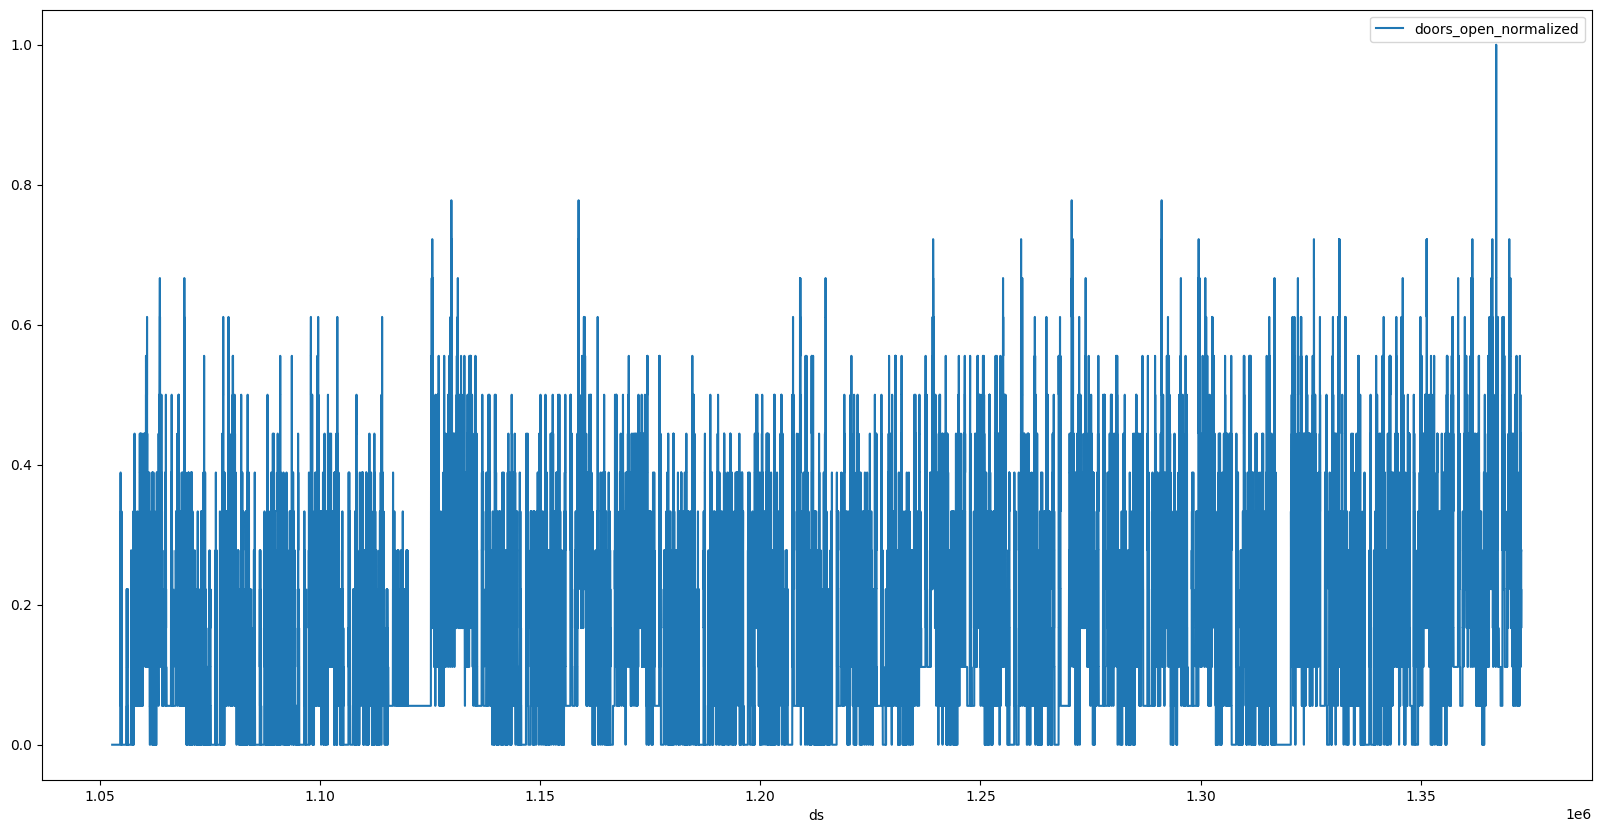

In [385]:
new_df_forplotting = new_df.reset_index()
new_df_forplotting.rename(columns = {'index': 'ds'}, inplace = True)
new_df_forplotting.plot('ds', 'doors_open_normalized', figsize = (20,10))

In [386]:
from prophet.plot import plot_plotly, plot_components_plotly

"""
Function to test prophet with
all_df: all the data you have
dummy_freq: frequency of datapoints you want the model to be fitted on test{day,hour,15min, 1 min}
regressors: set of columns in new_df you want to give to the model
cross_folds: amount of cross validation slices you want to use
changepoint_prior_scales: flexibility of the model to fit
"""

def prophet_model_prediction(all_df, dummy_freq, regressors, n_splits = 5, changepoint_prior_scales = [0.05], add_month = False, add_hour = False):
    
    best_month_rmse = 100000000
    ##make dic of all combinations of the regressors(this doesnt work fuckme)
    #regressor_combinations = itertools.product(regressors)
    regressor_combinations = regressors
   
    results = {}
    all_df_forplotting = all_df.reset_index()
    all_df_forplotting.rename(columns = {'index': 'ds'}, inplace = True)
    all_df_formonthcheck = pd.DataFrame({'ds' : all_df_forplotting['ds'], 'demand_kW' : all_df_forplotting['demand_kW']})
    
    #for each frequency in dummy_freq, resample the new_df to contain datapoints with given frequency
    for freq in dummy_freq:        
        resampled_dummy_df = all_df.resample(freq).last()  
        
        
        #for each regressor combination do the following
        for regs in regressor_combinations:  
            print(regs)
            start = time.time()
            prophet_dummy_df = pd.DataFrame({'ds': resampled_dummy_df.index, 'y' : resampled_dummy_df['demand_kW']})
            ##create the prophet_dummy_df that contains the regressors, column ds, y and reset the index
            for reg in regs: 
                
                prophet_dummy_df[str(reg)] = resampled_dummy_df[reg].copy()
                
            prophet_dummy_df = prophet_dummy_df.reset_index()
            prophet_dummy_df.drop(['index'], axis = 1, inplace = True)
            
            for scale in changepoint_prior_scales:
            ##do cross validation with n_splits
                ts = TimeSeriesSplit(n_splits=n_splits)
                count = 1
                train_rmses = []
                test_rmses = []
                for train, test in ts.split(prophet_dummy_df):              
                    print(f'Starting fold {count}')
                
                ##initiate a prophet object m and add each regressor to it
                    m = Prophet()
                    if add_month:
                        m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
                    if add_hour:
                        m.add_seasonality(name='hourly', period=0.042, fourier_order=5)
                    for reg in regs:
                        m.add_regressor(reg)
                    
                #create test and trainset                
                    cv_train, cv_test = prophet_dummy_df.iloc[train], prophet_dummy_df.iloc[test]                
                    future_test = cv_test.drop(['y'], axis = 1)
                    future_train = cv_train.drop(['y'], axis = 1)               

                    cv_train
                    #fit model
                    train_start = time.time()
                    m.fit(cv_train)
                    
                                          
                    train_stop = time.time()
                
                    #to predict future, create df for the coming future month
                    predict_start = time.time()
                    month_future_minutes = m.make_future_dataframe(periods = 86000, freq = 'min', include_history = False)
                    for reg in regs:               
                        all_df_formonthcheck[str(reg)] = all_df_forplotting[reg].copy()

                    month_future_minutes = month_future_minutes.merge(all_df_formonthcheck, on = 'ds', how = 'left') 

                    y_pred_test = m.predict(future_test) 
                    y_pred_train = m.predict(future_train)
                    y_pred_month = m.predict(month_future_minutes)
                    predict_stop = time.time()                
                
                #Calc rmse
                    rmse_start = time.time()
                    train_rmse = mean_squared_error(cv_train['y'], y_pred_train['yhat'], squared=False)
                    test_rmse = mean_squared_error(cv_test['y'], y_pred_test['yhat'], squared=False)                
                    month_rmse = mean_squared_error(month_future_minutes['demand_kW'], y_pred_month['yhat'], squared=False)
                    rmse_stop = time.time()        
                    train_rmses.append(train_rmse)
                    test_rmses.append(test_rmse)
                
                #print findings
                    timings = [(train_stop - train_start), (predict_stop - predict_start), (rmse_stop - rmse_start), (rmse_stop - train_start)]
                    print("these are the taken regulators:",   regs)
                    print(f'Fold {count} train error: {train_rmse}. Test error: {test_rmse}. month error: {month_rmse}.Time taken: {timings[3]} s.')
                    count += 1
                    if month_rmse < best_month_rmse:
                        best_month_rmse = month_rmse
                        best_regs = regs
                        best_train_rmse = train_rmse 
                        print("FUCKYES", freq)
                
                all_rmses = [train_rmses, test_rmses]
                m.plot(y_pred_month)
            ##for each split, do the following
            
    return [m, test_rmse, all_rmses, timings]
            
        #print(f'Mean Absolute Error = {mae}')
        #modelname = str(regressors) + 'with frequency' + str(freq)

Results:

What to test
1. test: resample data so that it is per hour/minute/15minutes/day. Minute data will be only of 2021, using y2021_df
2. test: different regressors
3. test: only use 2021 year
Results
1. 
            df length        best test score    monthscore      time to fit
minute       500.000                                             fucking long
15minutes    100.000          500                                 100secs
hour         26000            500                 240
day          1048             400                 370

2. 
            df length        best score          monthscore         
temp                              500              230         this is the best     
open door                                                 
23h


none                                                230 vgm ff checken dit
3. 

#### Test basic testing with 5 folds
best next months prediction is 345

In [438]:
new_df = new_df.set_index(pd.to_datetime(new_df['datetime_local']))
new_df = new_df.drop('datetime_local', axis=1)
print(new_df.dtypes)
has_datetime_index = pd.api.types.is_datetime64_any_dtype(new_df.index)
print(has_datetime_index)

index                                          int64
day                                            int64
hour                                           int64
Relative Humidity_interpolated_normalized    float64
Temperature_interpolated_normalized          float64
weight_1h_normalized                         float64
weight_5h_normalized                         float64
weight_10h_normalized                        float64
weight_23h_normalized                        float64
pallet_movement_5min_normalized              float64
doors_open_normalized                        float64
weekday_0                                       bool
weekday_1                                       bool
weekday_2                                       bool
weekday_3                                       bool
weekday_4                                       bool
weekday_5                                       bool
weekday_6                                       bool
year_2018                                     

In [439]:
prophet_model_prediction(new_df, ['15min'], [[]], n_splits = 5)

[]


KeyError: "['index'] not found in axis"

In [396]:
prophet_model_prediction(new_df, ['h'], [[]], n_splits = 5)

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

#### Test different regressors all together
leads to overfitting

['weight_1h_normalized', 'Relative Humidity_interpolated_normalized', 'Temperature_interpolated_normalized', 'weight_1h_normalized', 'weight_5h_normalized', 'weight_10h_normalized', 'weight_23h_normalized', 'pallet_movement_5min_normalized', 'doors_open_normalized']
Starting fold 1


14:47:12 - cmdstanpy - INFO - Chain [1] start processing
14:47:20 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['weight_1h_normalized', 'Relative Humidity_interpolated_normalized', 'Temperature_interpolated_normalized', 'weight_1h_normalized', 'weight_5h_normalized', 'weight_10h_normalized', 'weight_23h_normalized', 'pallet_movement_5min_normalized', 'doors_open_normalized']
Fold 1 train error: 186.39350028112202. Test error: 1954.5618452260621. month error: 405.39523201937936.Time taken: 39.037280321121216 s.
FUCKYES h
Starting fold 2


14:47:53 - cmdstanpy - INFO - Chain [1] start processing
14:48:19 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['weight_1h_normalized', 'Relative Humidity_interpolated_normalized', 'Temperature_interpolated_normalized', 'weight_1h_normalized', 'weight_5h_normalized', 'weight_10h_normalized', 'weight_23h_normalized', 'pallet_movement_5min_normalized', 'doors_open_normalized']
Fold 2 train error: 194.47441358566098. Test error: 486.11401022034516. month error: 308.4296233743879.Time taken: 57.19152355194092 s.
FUCKYES h


C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


"\n['weight_1h_normalized','Relative Humidity_interpolated_normalized',\n       'Temperature_interpolated_normalized', 'weight_1h_normalized',\n       'weight_5h_normalized', 'weight_10h_normalized',\n       'weight_23h_normalized', 'pallet_movement_5min_normalized',\n       'doors_open_normalized']\n"

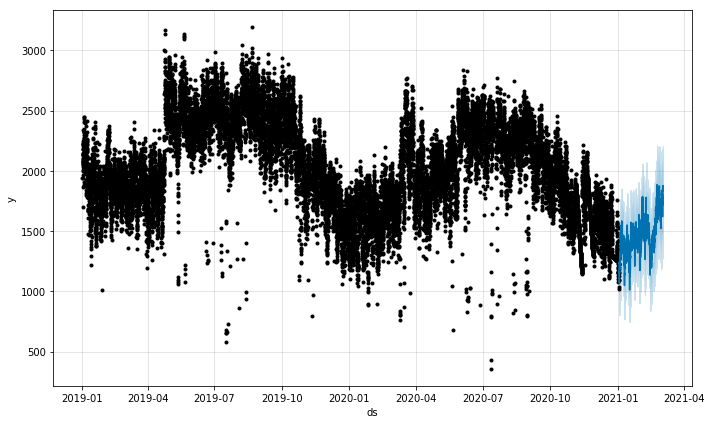

In [150]:
prophet_model_prediction(new_df, ['h'], [['weight_1h_normalized','Relative Humidity_interpolated_normalized',
       'Temperature_interpolated_normalized', 'weight_1h_normalized',
       'weight_5h_normalized', 'weight_10h_normalized',
       'weight_23h_normalized', 'pallet_movement_5min_normalized',
       'doors_open_normalized']], changepoint_prior_scales = [0.5])

#prophet_model_prediction(new_df, '[h, 15min, d]',['Temperature_interpolated_normalized'] )
#prophet_model_prediction(new_df,['Temperature_interpolated_normalized'] )
#prophet_model_prediction(new_df,['Temperature_interpolated_normalized'] )
"""
['weight_1h_normalized','Relative Humidity_interpolated_normalized',
       'Temperature_interpolated_normalized', 'weight_1h_normalized',
       'weight_5h_normalized', 'weight_10h_normalized',
       'weight_23h_normalized', 'pallet_movement_5min_normalized',
       'doors_open_normalized']
"""


#### Test all regressors individually
findings summarized: each regressor adds very very little and creates a lower train error and test erorr but also more overfitting

the train error is around 190-200 and the testerror is around 500 and the 2 months expectation error is around 237

In [163]:

prophet_model_prediction(new_df, ['h'], [['weight_1h_normalized','Relative Humidity_interpolated_normalized',
       'Temperature_interpolated_normalized', 'weight_1h_normalized',
       'weight_5h_normalized', 'weight_10h_normalized',
       'weight_23h_normalized', 'pallet_movement_5min_normalized',
       'doors_open_normalized']], changepoint_prior_scales = [0.5])


['weight_1h_normalized', 'Relative Humidity_interpolated_normalized', 'Temperature_interpolated_normalized', 'weight_1h_normalized', 'weight_5h_normalized', 'weight_10h_normalized', 'weight_23h_normalized', 'pallet_movement_5min_normalized', 'doors_open_normalized']
Starting fold 1


11:47:13 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

#### Test for y2021 data
findings, it is worse than using all years for both hour and 15 min frequency datapoints. 
for hour datafrequency and no regressors
fold 2:
Fold 2 train error: 303.91675967775853. Test error: 520.8706442095779. month error: 438.8608590535741

for 15 min data and no regressors
Fold 2 train error: 286.14426214818167. Test error: 512.0793509099431. month error: 435.20339042603246.

[]
Starting fold 1


12:03:27 - cmdstanpy - INFO - Chain [1] start processing
12:03:28 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: []
Fold 1 train error: 223.40578011580655. Test error: 668.8904599181957. month error: 670.9231813272472.Time taken: 28.107158184051514 s.
FUCKYES h
Starting fold 2


12:03:55 - cmdstanpy - INFO - Chain [1] start processing
12:03:57 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: []
Fold 2 train error: 303.91675967775853. Test error: 520.8706442095779. month error: 438.8608590535741.Time taken: 28.02803635597229 s.
FUCKYES h


C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


 520.8706442095779,
 [[223.40578011580655, 303.91675967775853],
  [668.8904599181957, 520.8706442095779]],
 [2.014176845550537,
  26.010867834091187,
  0.0029916763305664062,
  28.02803635597229]]

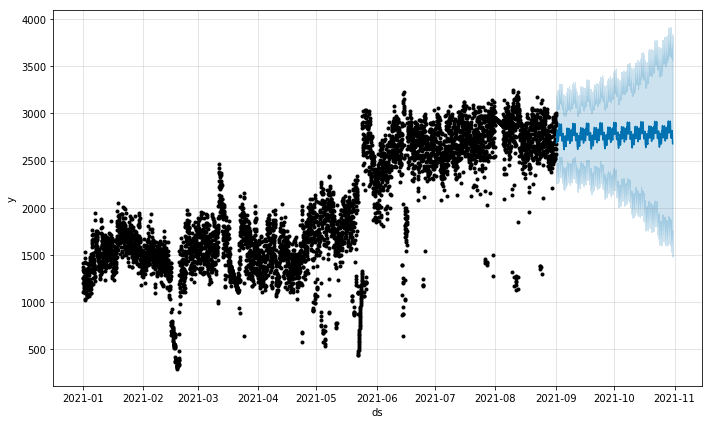

In [171]:
prophet_model_prediction(y2021_df, ['h'], [[]])

[]
Starting fold 1


12:05:38 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: []
Fold 1 train error: 189.01812385910895. Test error: 594.9293745740672. month error: 628.6131919671117.Time taken: 39.33832383155823 s.
FUCKYES 15min
Starting fold 2


12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:48 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: []
Fold 2 train error: 286.14426214818167. Test error: 512.0793509099431. month error: 435.20339042603246.Time taken: 63.530526876449585 s.
FUCKYES 15min


C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


 512.0793509099431,
 [[189.01812385910895, 286.14426214818167],
  [594.9293745740672, 512.0793509099431]],
 [30.870413780212402,
  32.65911316871643,
  0.0009999275207519531,
  63.530526876449585]]

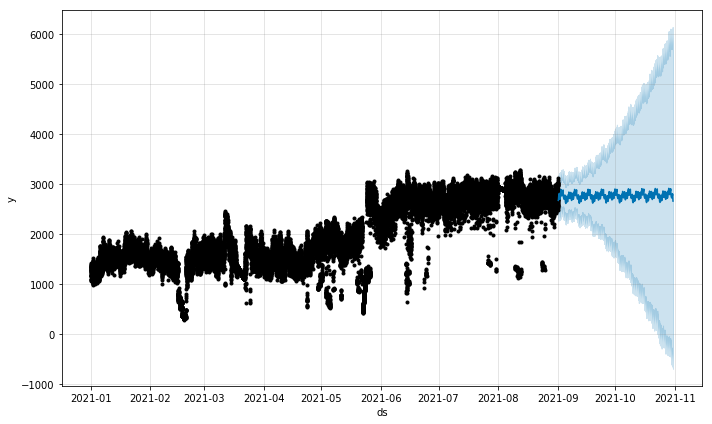

In [172]:
prophet_model_prediction(y2021_df, ['15min'], [[]])

#### Test for all years data
findings: overfitting is happening
for hour frequency
fold 2: train error 203, test error 418, month error 354

for 15 minutes frequency
fold 2: train error 200, test error 1107, month error 432 

[]
Starting fold 1


11:50:43 - cmdstanpy - INFO - Chain [1] start processing
11:50:51 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: []
Fold 1 train error: 196.3125044910378. Test error: 2265.4879383760235. month error: 464.5616569595577.Time taken: 38.549838066101074 s.
FUCKYES h
Starting fold 2


11:51:23 - cmdstanpy - INFO - Chain [1] start processing
11:51:40 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: []
Fold 2 train error: 203.91381051870533. Test error: 418.71210531217355. month error: 354.922055441972.Time taken: 50.10940957069397 s.
FUCKYES h


C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


 418.71210531217355,
 [[196.3125044910378, 203.91381051870533],
  [2265.4879383760235, 418.71210531217355]],
 [19.463414192199707,
  30.64308786392212,
  0.0029075145721435547,
  50.10940957069397]]

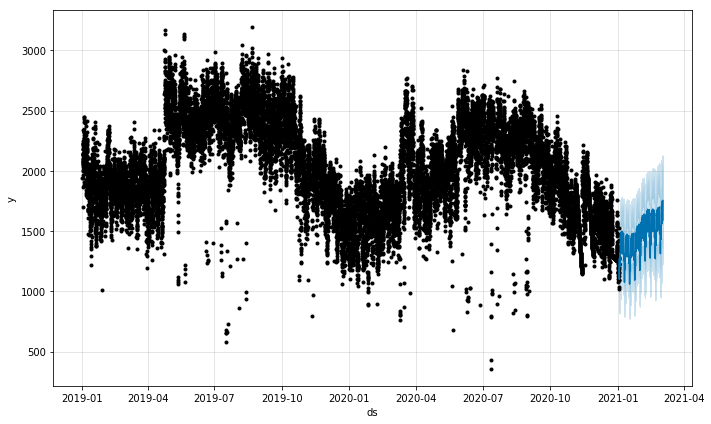

In [165]:
prophet_model_prediction(new_df, ['h'], [[]])

[]
Starting fold 1


11:56:14 - cmdstanpy - INFO - Chain [1] start processing
11:56:53 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: []
Fold 1 train error: 189.39454092553186. Test error: 2129.039748175744. month error: 433.8584412410189.Time taken: 83.04652738571167 s.
FUCKYES 15min
Starting fold 2


11:57:42 - cmdstanpy - INFO - Chain [1] start processing
11:59:16 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: []
Fold 2 train error: 199.90030098104614. Test error: 1107.7223223294563. month error: 432.7174338671553.Time taken: 149.62196326255798 s.
FUCKYES 15min


C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


 1107.7223223294563,
 [[189.39454092553186, 199.90030098104614],
  [2129.039748175744, 1107.7223223294563]],
 [101.24417662620544,
  48.37478542327881,
  0.0030012130737304688,
  149.62196326255798]]

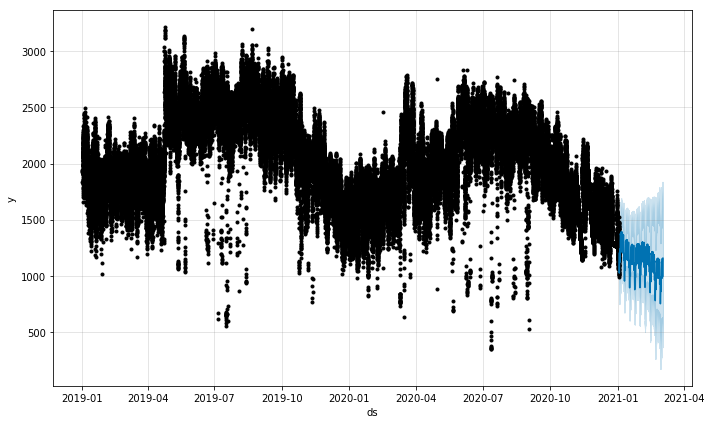

In [167]:
prophet_model_prediction(new_df, ['15min'], [[]])

#### Test to include month cycle/hour cycle
when using allyears, hourly, add month = true,
train error 202, test error 502, month error 365

[]
Starting fold 1


12:00:08 - cmdstanpy - INFO - Chain [1] start processing
12:00:15 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: []
Fold 1 train error: 194.2091494230637. Test error: 2231.7045222648753. month error: 456.4237391577021.Time taken: 36.38294577598572 s.
FUCKYES h
Starting fold 2


12:00:46 - cmdstanpy - INFO - Chain [1] start processing
12:01:15 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: []
Fold 2 train error: 202.2827619707178. Test error: 502.3392885972751. month error: 365.8842925358073.Time taken: 61.24579572677612 s.
FUCKYES h


C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


 502.3392885972751,
 [[194.2091494230637, 202.2827619707178],
  [2231.7045222648753, 502.3392885972751]],
 [31.354896545410156,
  29.888898134231567,
  0.002001047134399414,
  61.24579572677612]]

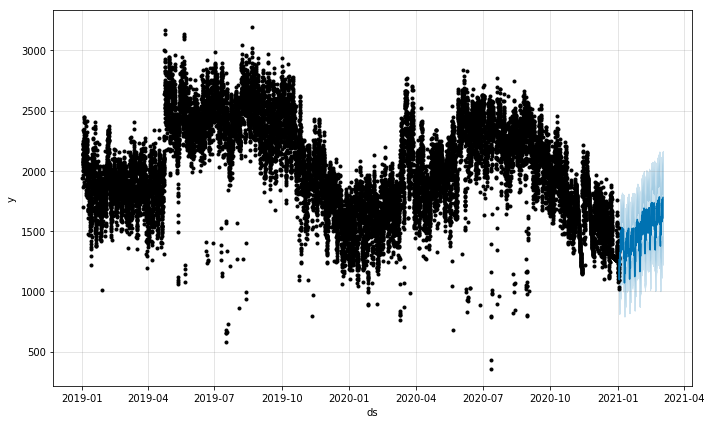

In [168]:
prophet_model_prediction(new_df, ['h'], [[]], add_month = True)

When using allyears, hourly, hour = true
train error 202, test error 532, month error 363

[]
Starting fold 1


12:01:47 - cmdstanpy - INFO - Chain [1] start processing
12:01:54 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: []
Fold 1 train error: 195.18865131371984. Test error: 2251.584158515704. month error: 461.93675834529097.Time taken: 36.55436658859253 s.
FUCKYES h
Starting fold 2


12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:52 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: []
Fold 2 train error: 203.395812490772. Test error: 532.6478951857009. month error: 363.2185668592877.Time taken: 61.62615919113159 s.
FUCKYES h


C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


 532.6478951857009,
 [[195.18865131371984, 203.395812490772],
  [2251.584158515704, 532.6478951857009]],
 [29.424286365509033,
  32.196871519088745,
  0.0050013065338134766,
  61.62615919113159]]

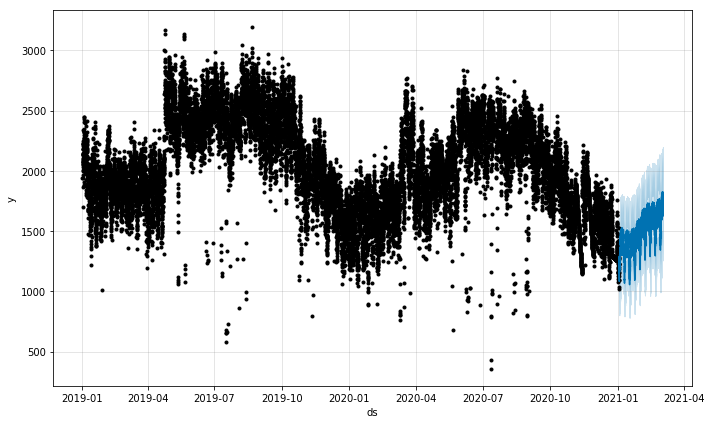

In [169]:
prophet_model_prediction(new_df, ['h'], [[]], add_hour = True)

#### Test different changepoint_prior_scales for Temp. 
Findings: there is no difference.

['Temperature_interpolated_normalized']
Starting fold 1


14:56:40 - cmdstanpy - INFO - Chain [1] start processing
14:56:46 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['Temperature_interpolated_normalized']
Fold 1 train error: 189.2823634971763. Test error: 1994.619584171204. month error: 428.12122360599153.Time taken: 35.35020732879639 s.
FUCKYES h
Starting fold 2


14:57:17 - cmdstanpy - INFO - Chain [1] start processing
14:57:35 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['Temperature_interpolated_normalized']
Fold 2 train error: 196.99180577407998. Test error: 480.83611480189137. month error: 329.7701693085633.Time taken: 47.75821924209595 s.
FUCKYES h


C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Starting fold 1


14:58:04 - cmdstanpy - INFO - Chain [1] start processing
14:58:10 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['Temperature_interpolated_normalized']
Fold 1 train error: 189.2823634971763. Test error: 1994.619584171204. month error: 428.12122360599153.Time taken: 32.849446296691895 s.
Starting fold 2


14:58:38 - cmdstanpy - INFO - Chain [1] start processing
14:58:56 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['Temperature_interpolated_normalized']
Fold 2 train error: 196.99180577407998. Test error: 480.83611480189137. month error: 329.7701693085633.Time taken: 47.348976135253906 s.


C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Starting fold 1


14:59:25 - cmdstanpy - INFO - Chain [1] start processing
14:59:31 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['Temperature_interpolated_normalized']
Fold 1 train error: 189.2823634971763. Test error: 1994.619584171204. month error: 428.12122360599153.Time taken: 32.854803800582886 s.
Starting fold 2


14:59:59 - cmdstanpy - INFO - Chain [1] start processing
15:00:16 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['Temperature_interpolated_normalized']
Fold 2 train error: 196.99180577407998. Test error: 480.83611480189137. month error: 329.7701693085633.Time taken: 47.38142991065979 s.


C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


 480.83611480189137,
 [[189.2823634971763, 196.99180577407998],
  [1994.619584171204, 480.83611480189137]],
 [19.01828122138977,
  28.361146926879883,
  0.0020017623901367188,
  47.38142991065979]]

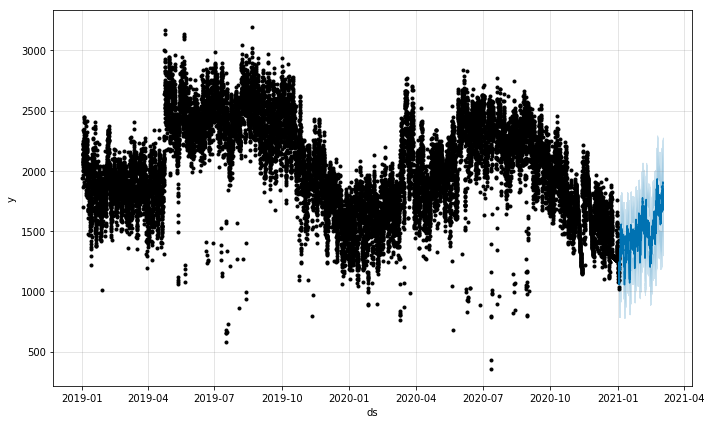

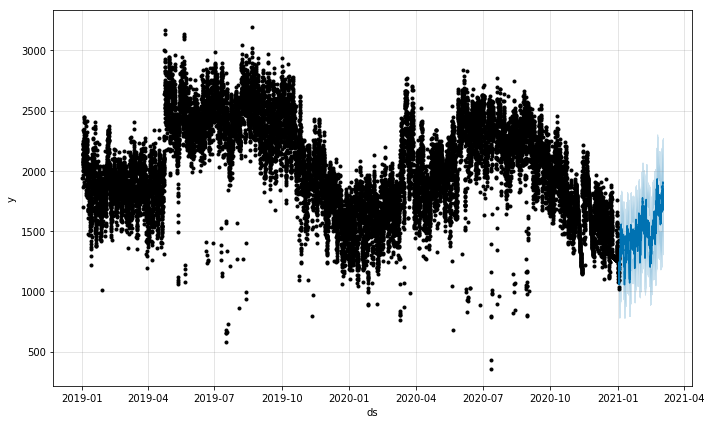

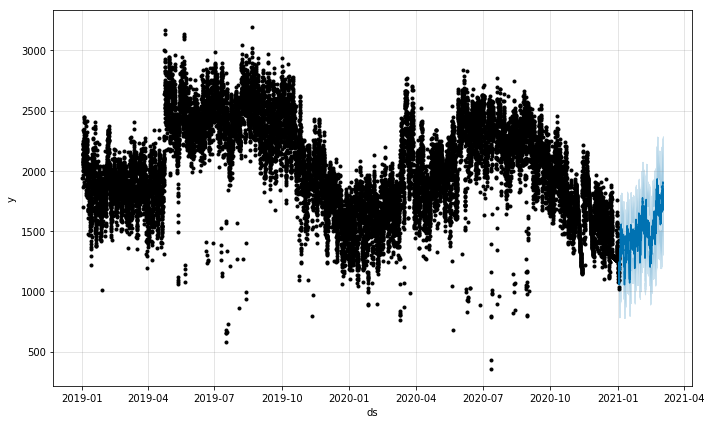

In [153]:
prophet_model_prediction(new_df, ['h'], [['Temperature_interpolated_normalized']], changepoint_prior_scales = [0.5, 0.1, 0.05])

#### Random Forest

In [ ]:
parameter_settings_RF = {
    'n_estimators': [10, 20, 50],
    'criterion': ['squared_error']#,
    #'max_depth': [2, 4, 6],
    #'min_samples_split': [2, 4, 8]
}
data = [X_train, Y_train, X_test, Y_test]
model_RF = RandomForestRegressor
#test_RF = model_optimizer(data, RandomForestRegressor_RF, parameter_settings_RF)

#### Gradient Boosting

Theory says: start with high n_estimators (between 100 and 500) and high max_leaf_nodes (between 2 and 8) and adjust learning_rate

Higher n_estimators works better, but more time expensive, 500 trees takes like 3 minutes to fit
Lower learning rate makes worse, but after 600, the n_estimators gain is not that much anymore.

max_leaf_nodes makes better, but 

max_leaf_nodes x learning rate: 
for small n_estimators; small learning rate, is smaller effect of more leaf_nodes 
for big n_estimators; small learning rate, is smaller effect of more leaf_nodes

max_leaf_nodes x n_estimators
Bigger positive effect of max_leaf_nodes when n_estimators is increased

learning rate x n_estimators
Learning rate makes a lot of the difference. 
The effect of learning rate becomes bigger as n_estimators increases. We jump from 0.1, 0.005, 0.001. The learning rate delta that gains the most positive effect becomes a smaller learning rate as n_estimators increases, which means that into the extreme, the effect of more n_estimators with learning rate 0.1 becomes nothing and then learning rate 0.005 will outperform maybe. 
Does this mean that learning rate of 0.05/0.01 will do better? 

Best combination is 
accuracy is 148: n_estimators = 500, learning rate = 0.1, max_leaf_nodes = 7. 
accuracy is 146: n_estimators = 600, learning rate = 0.05, max_leaf_nodes = 11. 
accurcay is 144: n_estimators = 700, learning rate = 0.05, max_leaf_nodes = 11. 

accuracy is 134: n_estimators = 600, learning rate = 0.1, max_leaf_nodes = 11

accuracy is 93: n_estimators = 800, learning_rate: 0.1, max_leaf_nodes : None, max_depth: 8

accuracy is 78: n_estimators = 800, learning_rate: 0.1, max_leaf_nodes : None, max_depth: 11

optimizing parameters:
n_estimators: [50, 100, 200, 300, 400, 500], ##higher number creates more accuracy but 1000 is too much because it takes like 60000 seconds to finish the algorithm
loss: ['huber'], 
learning_rate: [0.1, 0.005, 0.001], ##lower learning rate makes worse fitting, no of max_leaf_nodes and n_estimators this effect
max_leaf_nodes: [3, 5, 7],
max_depth: [None]



In [ ]:
parameter_settings_GB =    {
    
    'n_estimators': [100],
    'loss': ['squared_error'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [9, 10, 11]
}

test_GB = model_optimizer(data, model_GB, parameter_settings_GB)

In [ ]:
parameter_settings_good_GB =    {
    
    'n_estimators': [800, 1000],
    'loss': ['huber'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [6, 7,8]
}

test_GB = model_optimizer(data, model_GB, parameter_settings_good_GB)


In [ ]:
parameter_settings_GB = {
    'n_estimators': [600, 800, 1000],
    'loss': ['huber'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [5, 8, 11],
    'max_depth': [None]
    
}
data = [X_train, Y_train, X_test, Y_test]
model_GB = GradientBoostingRegressor


In [ ]:
test_GB = model_optimizer(data, model_GB, parameter_settings_GB)

In [ ]:
test_GB = model_optimizer(data, model_GB, parameter_settings_GB)
   # 'n_estimators': [600, 700, 800],
   # 'loss': ['huber'], 
   # 'learning_rate': [0.05, 0.01, 0.005],
   # 'max_leaf_nodes': [5, 8, 11],
   # 'max_depth': [None]
    

In [ ]:
test_GB = model_optimizer(data, model_GB, parameter_settings_GB)
    #'n_estimators': [50, 100, 200, 300, 400, 500],
    #'loss': ['huber'], 
    #'learning_rate': [0.05, 0.01], 
    #'max_leaf_nodes': [5, 7, 9],
    #'max_depth': [None]

In [ ]:
test_GB = model_optimizer(data, model_GB, parameter_settings_GB)
#parameter_settings_GB = {
#    'n_estimators': [50, 100, 200, 300, 400, 500],
#    'loss': ['huber'], 
#    'learning_rate': [0.1, 0.005, 0.001], 
#    'max_leaf_nodes': [3, 5, 7],
#    'max_depth': [None]

Evaluating Gradient Boosting
feature importance --> 
Generalizing out of distribution --> cross validation
evaluation metric --> Mean Absolute Error




In [ ]:
current_model_GB = GradientBoostingRegressor()

In [ ]:
parameter_settings_good_GB =    {
    
    'n_estimators': [800],
    'loss': ['huber'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [11]
}
current_model_GB = GradientBoostingRegressor
Results_GB = model_optimizer(data, current_model_GB, parameter_settings_good_GB)

#current_model_GB = current_model_GB(parameter_settings_good_GB)


In [ ]:
Results_GB.feature_importances_

## Visualizing sample set (X and Y) ~ D
I want to describe the Hypothesis space/Sample space (training set and the sample Distribution) to theorize about: 

1. Is it probable that the generalization error is similar to the empirical error?
2. What size must the number of training samples be given the amount of parameters/features we are trying to learn given the error rate/probability we chose. 

#### Describe Sample Space
The training samples we use is X_train, it is the features. We assume that all datapoints are drawn iid from distribution D. 

#### Describe Hypothesis Space
The hypothesis space is all the possible configurations your A can choose from. We try to find the best h to describe the relation between features xi and labels yi. It says that the probability that the space contains a training-consistent hypothesis with a true error rate > epsilon is lower than |H|e^{-epsilon m}.  

For decision trees, the hypothesis space is the set of possible decision trees.

#### Requirements to use PAC learning 
1. iid drawn examples
2. The Consistent Distribution Assumption: there is one probability distribution D that governs both training and testing examples.

#### Proof that a hypothesis space contains a good hypothesis, learnable with A
We want to find the probability of H containing a hypothesis with zero error on the training set and the true error rate greater than epsilon.

#### Proof that training set size m is big enough

As accuracy parameter \epsilon we pick 90% which is 0.1. With confidence parameter we pick 95% which is \delta = 0.05
We have m = 200000, so how big can our hypothesis space be?

function to calc. this can be found here:https://www.cis.upenn.edu/~danroth/Teaching/CS446-17/LectureNotesNew/colt/main.pdf on page 9. 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import time

def run_timeseries_model(data, model, n_splits = 5, verbose=False):
    """
    Function which receives a data and a model as input.
    Can also receive the amount of splits you want as input.
    For debugging purposes, set verbose to True.
    
    Outputs a list of:
        - The resulting model
        - The final RMSE
        - A list of the resulting Train RMSEs (per fold)
        - A list of the resulting Test RMSEs (per fold)
    """
    
    ts = TimeSeriesSplit(n_splits=n_splits)
    count = 1
    train_rmses = []
    test_rmses = []
    for train, test in ts.split(data):
        if verbose:
            print(f'Starting fold {count}')
        cv_train, cv_test = data.iloc[train], data.iloc[test]
        y_train = cv_train['demand_kW']
        x_train = cv_train.drop(['demand_kW'], axis=1)
        y_test = cv_test['demand_kW']
        x_test = cv_test.drop(['demand_kW'], axis=1)
        train_start = time.time()
        if verbose:
            print("Training model...")
        model.fit(x_train, y_train)
        train_stop = time.time()
        
        predict_start = time.time()
        if verbose:
            print("Predicting...")
        y_pred_test = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        predict_stop = time.time()
        
        rmse_start = time.time()
        if verbose:
            print("Calculating rmse's...")
        train_rmse = mean_squared_error(y_train, y_pred_train)#, squared=False)
        test_rmse = mean_squared_error(y_test, y_pred_test)#, squared=False)
        rmse_stop = time.time()
        
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        timings = [(train_stop - train_start), (predict_stop - predict_start), (rmse_stop - rmse_start), (rmse_stop - train_start)]
        if verbose:
            print(f'Fold {count} train error: {train_rmse}. Test error: {test_rmse}. Time taken: {timings[3]} s.')
        count += 1
    all_rmses = [train_rmses, test_rmses]
    return [model, test_rmse, all_rmses, timings]

In [ ]:
import itertools
import pickle

def find_optimal_parameters(data, model, params, n_splits=5, verbose=False):
    """
    Function which will find the optimal parameters within set boudaries.
    Receives as input:
    - The data
    - A model
    - The dictionary of parameters to optimize:
        - Key: parameter name
        - Value: List of testing parameter values.
    - The amount of Timeseries splits for crossvalidation (Standard: 5)
    - Whether information should be printed or not (Standard: False)
    """
    
    parameter_combinations = itertools.product(*params.values())
    results = {}
    count = 1
    for x in parameter_combinations:
        model_name = f'Model {count}'
        results[model_name] = [dict(zip(params.keys(), x))]
        count +=1
    lowest = 1000000000
    best_model = ""
    print(results['Model 1'])
    for model_name in results.keys():
        params_dict = results[model_name][0]
        print(f'Testing model {model_name} with parameters: {params_dict}')
        current_model = model(**params_dict)
        results[model_name].append(run_timeseries_model(data, current_model, n_splits=n_splits, verbose=verbose))
        print(results[model_name])
        print(f'Finished testing model. Test RMSE: {results[model_name][1][1]}. Time taken: {results[model_name][1][3][3]}.')
        if results[model_name][1][1] < lowest:
            lowest = results[model_name][1][1]
            best_model = model_name
    print(f"Optimization completed. Best model is {best_model} with parameters {results[model_name]}. \n RMSE is {results[model_name][1][1]}.")
    pickle.dump(best_model, open("Best_model.pkl", 'wb'))
    return results

In [ ]:
model_GB = GradientBoostingRegressor()
parameter_settings_good_GB =    {
    
    'n_estimators': [400, 600, 800],
    'loss': ['squared_error'], 
    'learning_rate': [0.1, 0.05, 0.01],
    'max_leaf_nodes': [None],
    'max_depth': [4, 6, 8]
}
parameter_settings_quick_GB =    {
    
    'n_estimators': [600],   
    'loss' : ['squared_error'],
    'learning_rate': [0.1, 0.3],
    'max_leaf_nodes': [None],
    'max_depth': [4, 8]
}

parameter_settings_qiuck_RF ={
    
    'n_estimators': [100]   
}

In [ ]:
find_optimal_parameters(new_df, GradientBoostingRegressor, parameter_settings_quick_GB, n_splits=5, verbose=True)